<p align="center">
  <img src="https://www.portafolio.co/files/article_new_multimedia/uploads/2023/10/12/652828e536642.jpeg" style="width:100%; max-width:900px; height:180px; object-fit:cover; border-radius:10px;"/>
</p>
<div style="text-align:center;">
  <h1 style="color:#FFD700; display:inline-block; margin:0;">Optimización del Transporte en Nueva York</h1>
  <p>
    <b>Green Taxi | Machine Learning & Data Science | CRISP-DM</b><br>
    <span style="font-size:1.1em;">Análisis y predicción de tarifas y duración de viajes usando datos reales de taxis verdes de NYC.</span>
  </p>
</div>

# 01.-Data Understanding

In [1]:
import sys, subprocess

# Función lambda para verificar e instalar
instalar = lambda p: subprocess.call([sys.executable, "-c", f"import {p}"]) and subprocess.call([sys.executable, "-m", "pip", "install", p, "-q"])

# Actualizar pip
subprocess.call([sys.executable, "-m", "pip", "install", "--upgrade", "pip", "-q"])

# Verificar e instalar condicionalmente
if instalar("pyarrow") == 0: print("PyArrow instalado/verificado")
if instalar("fastparquet") == 0: print("FastParquet instalado/verificado")

print("Listo para usar")

PyArrow instalado/verificado
FastParquet instalado/verificado
Listo para usar


In [2]:
# Ignorar warnings
import warnings
warnings.filterwarnings('ignore')

# Importaciones base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
# Establece el tema global
sns.set_theme(
    style="whitegrid",       # El estilo del gráfico (fondo y cuadrícula)
    palette="colorblind",        # La paleta de colores
    font="sans-serif",            # La familia de la fuente
    font_scale=0.9,          # Escala de la fuente
    rc={"axes.titlesize": 14, "axes.labelsize": 12, "xtick.labelsize": 10, "ytick.labelsize": 10}
)

In [3]:
# Pagina Taxi & Limousine Commission (TLC) NYC - Fuentes de Datos originales y documentación completa de los datasets
# Generar URL del la pagina web
url_base = "https://www1.nyc.gov/assets/tlc/downloads/pdf/"

# Carga de archivo de datos tipo parquet

In [4]:
# Configuración de visualización
url ="https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-06.parquet"
df = pd.read_parquet(url, engine="pyarrow")

In [5]:
# Definir el orden deseado de las columnas (nombres en inglés)
column_order = [
    'VendorID',
    'lpep_pickup_datetime',  # Fecha y hora de recogida del pasajero
    'lpep_dropoff_datetime', # Fecha y hora de bajada del pasajero
    'PULocationID',          # Zona de recogida del pasajero
    'DOLocationID',          # Zona de destino del pasajero
    'trip_distance',         # Distancia recorrida en millas
    'passenger_count',       # Número de pasajeros en el viaje
    'trip_type',             # Tipo de servicio (calle/despacho)
    'store_and_fwd_flag',    # Indicador de almacenamiento temporal en vehículo
    'RatecodeID',            # Código de tarifa aplicada al viaje
    'fare_amount',           # Tarifa base del viaje
    'extra',                 # Cargos adicionales y suplementos
    'mta_tax',               # Impuesto MTA aplicado
    'tolls_amount',          # Monto total de peajes
    'improvement_surcharge', # Recargo por mejora del servicio
    'congestion_surcharge',  # Recargo por congestión de NYS
    'cbd_congestion_fee',    # Tarifa por congestión Zona CBD MTA
    'ehail_fee',             # Tarifa de servicio e-hail (obsoleta)
    'tip_amount',            # Propina pagada (solo tarjeta)
    'payment_type',          # Método de pago utilizado
    'total_amount'           # Monto total cobrado al pasajero
]

# Verificar que todas las columnas existan en el DataFrame
missing_columns = [col for col in column_order if col not in df.columns]
if missing_columns:
    print(f"Advertencia: Las siguientes columnas no se encuentran en el DataFrame: {missing_columns}")
    column_order = [col for col in column_order if col in df.columns]

# Reordenar el DataFrame
df = df[column_order]

In [6]:
# Mostrar las primeras 10 filas del DataFrame
df.head(10)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,passenger_count,trip_type,store_and_fwd_flag,RatecodeID,...,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,cbd_congestion_fee,ehail_fee,tip_amount,payment_type,total_amount
0,2,2025-06-01 00:33:43,2025-06-01 01:04:33,74,132,19.60,1.0,1.0,N,2.0,...,0.0,0.5,6.94,1.0,0.0,0.0,NaN,19.61,1.0,98.05
1,2,2025-06-01 00:07:45,2025-06-01 00:14:52,75,74,1.37,2.0,1.0,N,1.0,...,1.0,0.5,0.00,1.0,0.0,0.0,NaN,0.00,2.0,11.80
2,2,2025-06-01 00:24:07,2025-06-01 00:48:24,83,83,4.11,1.0,1.0,N,1.0,...,1.0,0.5,0.00,1.0,0.0,0.0,NaN,0.00,2.0,27.90
3,2,2025-06-01 00:00:14,2025-06-01 00:08:29,97,49,1.29,1.0,1.0,N,1.0,...,1.0,0.5,0.00,1.0,0.0,0.0,NaN,2.36,1.0,14.16
4,2,2025-06-01 00:31:15,2025-06-01 00:43:35,66,25,1.97,1.0,1.0,N,1.0,...,1.0,0.5,0.00,1.0,0.0,0.0,NaN,0.00,1.0,16.00
5,2,2025-06-01 00:31:18,2025-06-01 00:31:58,130,130,0.04,1.0,2.0,N,5.0,...,0.0,0.0,0.00,1.0,0.0,0.0,NaN,0.00,2.0,66.00
6,2,2025-06-01 00:33:00,2025-06-01 00:33:04,130,130,0.00,1.0,2.0,N,5.0,...,0.0,0.0,0.00,1.0,0.0,0.0,NaN,0.00,1.0,66.00
7,2,2025-06-01 00:05:42,2025-06-01 00:05:49,244,244,0.00,1.0,2.0,N,5.0,...,0.0,0.0,0.00,1.0,0.0,0.0,NaN,2.10,1.0,12.60
8,2,2025-06-01 00:36:58,2025-06-01 00:46:31,130,205,2.32,1.0,1.0,N,1.0,...,1.0,0.5,0.00,1.0,0.0,0.0,NaN,3.06,1.0,18.36
9,1,2025-06-01 00:51:33,2025-06-01 01:07:17,255,49,3.40,1.0,2.0,N,5.0,...,0.0,0.0,0.00,0.0,0.0,0.0,NaN,15.00,1.0,65.00


In [7]:
df.tail(10)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,passenger_count,trip_type,store_and_fwd_flag,RatecodeID,...,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,cbd_congestion_fee,ehail_fee,tip_amount,payment_type,total_amount
49380,2,2025-06-30 19:14:00,2025-06-30 19:25:00,181,54,1.84,NaN,NaN,None,NaN,...,0.0,0.5,0.00,1.0,NaN,0.00,NaN,2.91,NaN,19.10
49381,6,2025-06-30 19:38:04,2025-06-30 20:14:35,68,49,6.55,NaN,NaN,None,NaN,...,0.0,0.5,0.00,0.3,NaN,0.00,NaN,0.00,NaN,42.95
49382,6,2025-06-30 19:22:52,2025-06-30 20:41:44,246,121,12.03,NaN,NaN,None,NaN,...,0.0,0.5,0.00,0.3,NaN,0.00,NaN,0.00,NaN,45.26
49383,6,2025-06-30 20:47:57,2025-06-30 21:12:27,87,235,13.55,NaN,NaN,None,NaN,...,0.0,0.5,0.00,0.3,NaN,0.00,NaN,0.00,NaN,34.21
49384,2,2025-06-30 20:11:00,2025-06-30 20:25:00,66,231,2.18,NaN,NaN,None,NaN,...,0.0,0.5,0.00,1.0,NaN,0.75,NaN,2.11,NaN,19.70
49385,2,2025-06-30 20:35:00,2025-06-30 20:43:00,152,42,1.26,NaN,NaN,None,NaN,...,0.0,0.5,0.00,1.0,NaN,0.00,NaN,3.02,NaN,18.10
49386,2,2025-06-30 21:35:00,2025-06-30 21:46:00,66,87,2.20,NaN,NaN,None,NaN,...,0.0,0.5,0.00,1.0,NaN,0.75,NaN,3.58,NaN,21.46
49387,2,2025-06-30 22:51:00,2025-06-30 23:14:00,33,164,6.60,NaN,NaN,None,NaN,...,0.0,0.5,0.00,1.0,NaN,0.75,NaN,6.90,NaN,41.41
49388,2,2025-06-30 22:13:00,2025-06-30 22:25:00,42,236,2.52,NaN,NaN,None,NaN,...,0.0,0.5,0.00,1.0,NaN,0.00,NaN,4.50,NaN,26.98
49389,6,2025-06-30 23:18:19,2025-07-01 00:23:40,196,243,14.48,NaN,NaN,None,NaN,...,0.0,0.5,6.94,0.3,NaN,0.00,NaN,0.00,NaN,37.33


In [8]:
df.describe(include='float64').round(2).T

,count,mean,std,min,25%,50%,75%,max
trip_distance,49390.0,10.12,618.78,0.00,1.26,2.03,3.56,77463.55
passenger_count,45605.0,1.29,0.96,0.00,1.00,1.00,1.00,9.00
trip_type,45599.0,1.06,0.23,1.00,1.00,1.00,1.00,2.00
RatecodeID,45605.0,1.29,2.07,1.00,1.00,1.00,1.00,99.00
fare_amount,49390.0,18.80,18.13,-200.00,10.00,14.20,21.20,588.20
extra,49390.0,0.88,1.38,-5.00,0.00,0.00,1.00,7.50
mta_tax,49390.0,0.57,0.34,-0.50,0.50,0.50,0.50,1.50
tolls_amount,49390.0,0.27,1.48,0.00,0.00,0.00,0.00,49.94
improvement_surcharge,49390.0,0.96,0.19,-1.00,1.00,1.00,1.00,1.00
congestion_surcharge,45605.0,0.90,1.29,-2.75,0.00,0.00,2.75,2.75


In [9]:
df.describe(include='float64').round(2).T.duplicated()

trip_distance            False
passenger_count          False
trip_type                False
RatecodeID               False
fare_amount              False
extra                    False
mta_tax                  False
tolls_amount             False
improvement_surcharge    False
congestion_surcharge     False
cbd_congestion_fee       False
ehail_fee                False
tip_amount               False
payment_type             False
total_amount             False
dtype: bool

In [10]:
df.describe(include='int32').T

,count,mean,std,min,25%,50%,75%,max
VendorID,49390.0,2.035574,0.819152,1.0,2.0,2.0,2.0,6.0
PULocationID,49390.0,96.857198,56.637737,3.0,74.0,75.0,97.0,265.0
DOLocationID,49390.0,143.368941,77.625091,1.0,74.0,140.0,231.0,265.0


In [11]:
df.describe(include='int32').T.duplicated()

VendorID        False
PULocationID    False
DOLocationID    False
dtype: bool

In [12]:
df.describe(include='object').T

,count,unique,top,freq
store_and_fwd_flag,45605,2,N,45468


In [13]:
df.describe(include='object').T.duplicated()

store_and_fwd_flag    False
dtype: bool

In [14]:
# Valores únicos de la columna 'store_and_fwd_flag'
df['store_and_fwd_flag'].unique().tolist()

['N', 'Y', None]

In [15]:
# Columnas datetime correctamente parseadas
df.describe(include='datetime').T

,count,mean,min,25%,50%,75%,max
lpep_pickup_datetime,49390,2025-06-16 00:46:45.446649,2025-05-29 19:20:43,2025-06-08 18:52:53.750000,2025-06-15 21:35:23,2025-06-23 14:10:45.250000,2025-07-01 20:35:08
lpep_dropoff_datetime,49390,2025-06-16 01:06:20.370560,2025-05-29 19:42:35,2025-06-08 19:12:57.750000,2025-06-15 21:53:39.500000,2025-06-23 14:30:57,2025-07-01 21:11:08


In [16]:
# Total de columnas y filas 
df.shape[1], df.shape[0]

(21, 49390)

In [17]:
# Información del DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49390 entries, 0 to 49389
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               49390 non-null  int32         
 1   lpep_pickup_datetime   49390 non-null  datetime64[us]
 2   lpep_dropoff_datetime  49390 non-null  datetime64[us]
 3   PULocationID           49390 non-null  int32         
 4   DOLocationID           49390 non-null  int32         
 5   trip_distance          49390 non-null  float64       
 6   passenger_count        45605 non-null  float64       
 7   trip_type              45599 non-null  float64       
 8   store_and_fwd_flag     45605 non-null  object        
 9   RatecodeID             45605 non-null  float64       
 10  fare_amount            49390 non-null  float64       
 11  extra                  49390 non-null  float64       
 12  mta_tax                49390 non-null  float64       
 13  t

| Field Name | Description |
|------------|-------------|
| VendorID | A code indicating the LPEP provider that provided the record. 1 = Creative Mobile Technologies, LLC; 2 = Curb Mobility, LLC; 6 = Myle Technologies Inc |
| lpep_pickup_datetime | The date and time when the meter was engaged |
| lpep_dropoff_datetime | The date and time when the meter was disengaged |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
| trip_distance | The elapsed trip distance in miles reported by the taximeter |
| passenger_count | The number of passengers in the vehicle |
| trip_type | A code indicating whether the trip was a street-hall or a dispatch that is automatically assigned based on the metered rate in use but can be altered by the driver. 1 = Street-hall; 2 = Dispatch |
| store_and_fwd_flag | This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka "store and forward," because the vehicle did not have a connection to the server |
| RatecodeID | The final rate code in effect at the end of the trip. 1 = Standard rate; 2 = JFK; 3 = Newark; 4 = Nassau or Westchester; 5 = Negotiated fare; 6 = Group ride; 99 = Null/unknown |
| fare_amount | The time-and-distance fare calculated by the meter |
| extra | Miscellaneous extras and surcharges |
| mta_tax | Tax that is automatically triggered based on the metered rate in use |
| tolls_amount | Total amount of all tolls paid in trip |
| improvement_surcharge | Improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015 |
| congestion_surcharge | Total amount collected in trip for NYS congestion surcharge |
| cbd_congestion_fee | Per-trip charge for MTA's Congestion Relief Zone starting Jan. 5, 2025 |
| ehail_fee | No description available in data dictionary |
| tip_amount | Tip amount – This field is automatically populated for credit card tips. Cash tips are not included |
| payment_type | A numeric code signifying how the passenger paid for the trip. 0 = Flex Fare trip; 1 = Credit card; 2 = Cash; 3 = No charge; 4 = Dispute; 5 = Unknown; 6 = Voided trip |
| total_amount | The total amount charged to passengers. Does not include cash tips |

In [18]:
# Spreadsheet para diccionario de datos completo
data_types = pd.DataFrame({'Variable': df.columns.tolist(),'Tipo': df.dtypes.astype(str).values})
data_types['Dato Estadístico'] = data_types['Tipo'].apply(lambda x: 'Fecha/Hora' if 'datetime' in x else ('Numérico Discreto' if 'int' in x else ('Numérico Continuo' if 'float' in x else 'Categórico')))
# Unidad de medida (21 elementos)
# Unidad de medida (21 elementos) - REORGANIZADO
data_types['Unidad de Medida'] = [
    'ID',                   # VendorID
    'Fecha/Hora',           # lpep_pickup_datetime
    'Fecha/Hora',           # lpep_dropoff_datetime
    'ID de Zona TLC',       # PULocationID
    'ID de Zona TLC',       # DOLocationID
    'Millas',               # trip_distance
    'Cantidad de personas', # passenger_count
    'Código',               # trip_type
    'Flag (Y/N)',           # store_and_fwd_flag
    'Código',               # RatecodeID
    'Dólares ($)',          # fare_amount
    'Dólares ($)',          # extra
    'Dólares ($)',          # mta_tax
    'Dólares ($)',          # tolls_amount
    'Dólares ($)',          # improvement_surcharge
    'Dólares ($)',          # congestion_surcharge
    'Dólares ($)',          # cbd_congestion_fee
    'Dólares ($)',          # ehail_fee
    'Dólares ($)',          # tip_amount
    'Código',               # payment_type
    'Dólares ($)'           # total_amount
]

data_types['Descripción (Español)'] = [
    'Código del proveedor del servicio',                # VendorID
    'Fecha y hora de inicio del viaje',                 # lpep_pickup_datetime
    'Fecha y hora de fin del viaje',                    # lpep_dropoff_datetime
    'Zona de recogida del pasajero',                    # PULocationID
    'Zona de destino del pasajero',                     # DOLocationID
    'Distancia recorrida en millas',                    # trip_distance
    'Número de pasajeros en el viaje',                  # passenger_count
    'Tipo de servicio (calle/despacho)',               # trip_type
    'Indicador de almacenamiento temporal en vehículo', # store_and_fwd_flag
    'Código de tarifa aplicada al viaje',               # RatecodeID
    'Tarifa base del viaje',                            # fare_amount
    'Cargos adicionales y suplementos',                 # extra
    'Impuesto MTA aplicado',                            # mta_tax
    'Monto total de peajes',                            # tolls_amount
    'Recargo por mejora del servicio',                  # improvement_surcharge
    'Recargo por congestión de NYS',                   # congestion_surcharge
    'Tarifa por congestión Zona CBD MTA',              # cbd_congestion_fee
    'Tarifa de servicio e-hail (obsoleta)',            # ehail_fee
    'Propina pagada (solo tarjeta)',                    # tip_amount
    'Método de pago utilizado',                         # payment_type
    'Monto total cobrado al pasajero'                   # total_amount
]
data_types = data_types[['Variable', 'Tipo', 'Dato Estadístico', 'Unidad de Medida', 'Descripción (Español)']]
data_types

,Variable,Tipo,Dato Estadístico,Unidad de Medida,Descripción (Español)
0,VendorID,int32,Numérico Discreto,ID,Código del proveedor del servicio
1,lpep_pickup_datetime,datetime64[us],Fecha/Hora,Fecha/Hora,Fecha y hora de inicio del viaje
2,lpep_dropoff_datetime,datetime64[us],Fecha/Hora,Fecha/Hora,Fecha y hora de fin del viaje
3,PULocationID,int32,Numérico Discreto,ID de Zona TLC,Zona de recogida del pasajero
4,DOLocationID,int32,Numérico Discreto,ID de Zona TLC,Zona de destino del pasajero
5,trip_distance,float64,Numérico Continuo,Millas,Distancia recorrida en millas
6,passenger_count,float64,Numérico Continuo,Cantidad de personas,Número de pasajeros en el viaje
7,trip_type,float64,Numérico Continuo,Código,Tipo de servicio (calle/despacho)
8,store_and_fwd_flag,object,Categórico,Flag (Y/N),Indicador de almacenamiento temporal en vehículo
9,RatecodeID,float64,Numérico Continuo,Código,Código de tarifa aplicada al viaje


In [19]:
df.columns[df.isnull().any()].tolist()

['passenger_count',
 'trip_type',
 'store_and_fwd_flag',
 'RatecodeID',
 'congestion_surcharge',
 'ehail_fee',
 'payment_type']

In [20]:
# Porcentaje de valores nulos por columna (antes de limpieza)
missing_values = df.isnull().sum()/len(df)
missing_values = missing_values[missing_values > 0].round(3).sort_values(ascending=False)*100
missing_values

ehail_fee               100.0
trip_type                 7.7
passenger_count           7.7
store_and_fwd_flag        7.7
RatecodeID                7.7
congestion_surcharge      7.7
payment_type              7.7
dtype: float64

In [21]:
# Spreadsheet para diccionario de datos completo
data_types['Non-Null'] = df.notnull().sum().values
data_types['Nulos'] = df.isnull().sum().values
data_types['% Nulos'] = (data_types['Nulos'] / df.shape[0] * 100).round(2)
data_types['% Nulos'] = data_types['% Nulos'].astype(str) + '%'
data_types['Descripción (Español)'] = [
    'Código del proveedor del servicio',                # VendorID
    'Fecha y hora de inicio del viaje',                 # lpep_pickup_datetime
    'Fecha y hora de fin del viaje',                    # lpep_dropoff_datetime
    'Zona de recogida del pasajero',                    # PULocationID
    'Zona de destino del pasajero',                     # DOLocationID
    'Distancia recorrida en millas',                    # trip_distance
    'Número de pasajeros en el viaje',                  # passenger_count
    'Tipo de servicio (calle/despacho)',               # trip_type
    'Indicador de almacenamiento temporal en vehículo', # store_and_fwd_flag
    'Código de tarifa aplicada al viaje',               # RatecodeID
    'Tarifa base del viaje',                            # fare_amount
    'Cargos adicionales y suplementos',                 # extra
    'Impuesto MTA aplicado',                            # mta_tax
    'Monto total de peajes',                            # tolls_amount
    'Recargo por mejora del servicio',                  # improvement_surcharge
    'Recargo por congestión de NYS',                   # congestion_surcharge
    'Tarifa por congestión Zona CBD MTA',              # cbd_congestion_fee
    'Tarifa de servicio e-hail (obsoleta)',            # ehail_fee
    'Propina pagada (solo tarjeta)',                    # tip_amount
    'Método de pago utilizado',                         # payment_type
    'Monto total cobrado al pasajero'                   # total_amount
]
data_types = data_types[['Variable','Non-Null', 'Nulos', '% Nulos','Descripción (Español)']]
data_types

,Variable,Non-Null,Nulos,% Nulos,Descripción (Español)
0,VendorID,49390,0,0.0%,Código del proveedor del servicio
1,lpep_pickup_datetime,49390,0,0.0%,Fecha y hora de inicio del viaje
2,lpep_dropoff_datetime,49390,0,0.0%,Fecha y hora de fin del viaje
3,PULocationID,49390,0,0.0%,Zona de recogida del pasajero
4,DOLocationID,49390,0,0.0%,Zona de destino del pasajero
5,trip_distance,49390,0,0.0%,Distancia recorrida en millas
6,passenger_count,45605,3785,7.66%,Número de pasajeros en el viaje
7,trip_type,45599,3791,7.68%,Tipo de servicio (calle/despacho)
8,store_and_fwd_flag,45605,3785,7.66%,Indicador de almacenamiento temporal en vehículo
9,RatecodeID,45605,3785,7.66%,Código de tarifa aplicada al viaje


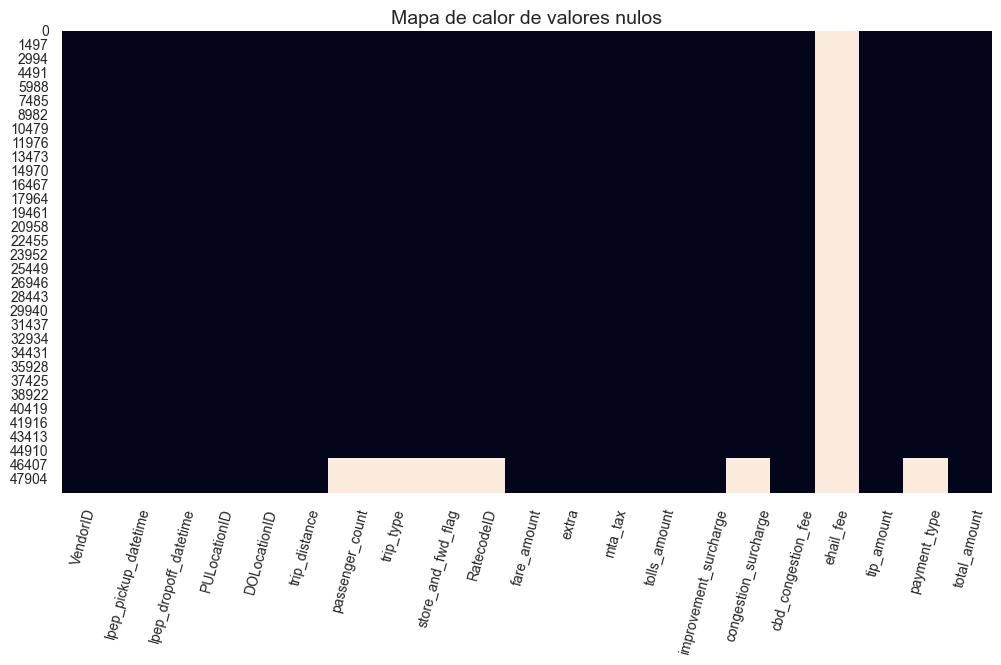

In [22]:
# Mapa de calor de valores nulos
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Mapa de calor de valores nulos")
ax = plt.gca()
ax.tick_params(axis='x', rotation=75)

In [23]:
df.describe(percentiles = [.1,.25, .5, .75, .90]).round(2).T

,count,mean,min,10%,25%,50%,75%,90%,max,std
VendorID,49390.0,2.04,1.0,1.0,2.0,2.0,2.0,2.0,6.0,0.82
lpep_pickup_datetime,49390,2025-06-16 00:46:45.446649,2025-05-29 19:20:43,2025-06-04 08:37:25.300000,2025-06-08 18:52:53.750000,2025-06-15 21:35:23,2025-06-23 14:10:45.250000,2025-06-27 16:39:17.700000,2025-07-01 20:35:08,NaN
lpep_dropoff_datetime,49390,2025-06-16 01:06:20.370560,2025-05-29 19:42:35,2025-06-04 08:55:40.800000,2025-06-08 19:12:57.750000,2025-06-15 21:53:39.500000,2025-06-23 14:30:57,2025-06-27 16:57:59,2025-07-01 21:11:08,NaN
PULocationID,49390.0,96.86,3.0,42.0,74.0,75.0,97.0,193.0,265.0,56.64
DOLocationID,49390.0,143.37,1.0,42.0,74.0,140.0,231.0,243.0,265.0,77.63
trip_distance,49390.0,10.12,0.0,0.7,1.26,2.03,3.56,6.88,77463.55,618.78
passenger_count,45605.0,1.29,0.0,1.0,1.0,1.0,1.0,2.0,9.0,0.96
trip_type,45599.0,1.06,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.23
RatecodeID,45605.0,1.29,1.0,1.0,1.0,1.0,1.0,1.0,99.0,2.07
fare_amount,49390.0,18.8,-200.0,6.5,10.0,14.2,21.2,35.0,588.2,18.13


In [24]:
%pip install --quiet scipy
# Calcular la media recortada de las variables numéricas del dataset agregando las columnas de media, mediana y media recortada, min, max
from scipy.stats import trim_mean
numeric_cols = df.select_dtypes(include=['float64', 'int32']).columns
trimmed_means = {col: trim_mean(df[col].dropna(), proportiontocut=0.1) for col in numeric_cols}
summary_stats = df[numeric_cols].agg(['mean', 'median', 'min', 'max']).round(2).T
summary_stats['trim_mean'] = pd.Series(trimmed_means).round(2)
summary_stats = summary_stats[['min', 'mean', 'trim_mean', 'median', 'max']]
summary_stats.round(2)
summary_stats


Note: you may need to restart the kernel to use updated packages.


,min,mean,trim_mean,median,max
VendorID,1.00,2.04,1.99,2.00,6.00
PULocationID,3.00,96.86,87.63,75.00,265.00
DOLocationID,1.00,143.37,143.23,140.00,265.00
trip_distance,0.00,10.12,2.44,2.03,77463.55
passenger_count,0.00,1.29,1.07,1.00,9.00
trip_type,1.00,1.06,1.00,1.00,2.00
RatecodeID,1.00,1.29,1.00,1.00,99.00
fare_amount,-200.00,18.80,15.67,14.20,588.20
extra,-5.00,0.88,0.63,0.00,7.50
mta_tax,-0.50,0.57,0.50,0.50,1.50


In [25]:
binnedTotalAmount = pd.cut(df['total_amount'], bins=10)
binnedTotalAmount.value_counts().sort_index()

total_amount
(-201.791, -121.93]        3
(-121.93, -42.86]         10
(-42.86, 36.21]        41244
(36.21, 115.28]         7754
(115.28, 194.35]         321
(194.35, 273.42]          33
(273.42, 352.49]          22
(352.49, 431.56]           2
(431.56, 510.63]           0
(510.63, 589.7]            1
Name: count, dtype: int64

In [26]:
# Tabla de frecuencia  de la columna Total Amount con las distribucione de frecuencias absolutas y relativas con rango de valores de 0 a 100
freq_table = pd.cut(df['total_amount'], bins=range(-220, 110, 10)).value_counts().sort_index()
freq_table = freq_table.reset_index()
freq_table.columns = ['Rango de Total Amount', 'Frecuencia Absoluta']
freq_table['Frecuencia Relativa (%)'] = (freq_table['Frecuencia Absoluta'] / freq_table['Frecuencia Absoluta'].sum() * 100).round(2)
freq_table

,Rango de Total Amount,Frecuencia Absoluta,Frecuencia Relativa (%)
0,"(-220, -210]",0,0.00
1,"(-210, -200]",1,0.00
2,"(-200, -190]",0,0.00
3,"(-190, -180]",0,0.00
4,"(-180, -170]",0,0.00
5,"(-170, -160]",0,0.00
6,"(-160, -150]",2,0.00
7,"(-150, -140]",0,0.00
8,"(-140, -130]",0,0.00
9,"(-130, -120]",0,0.00


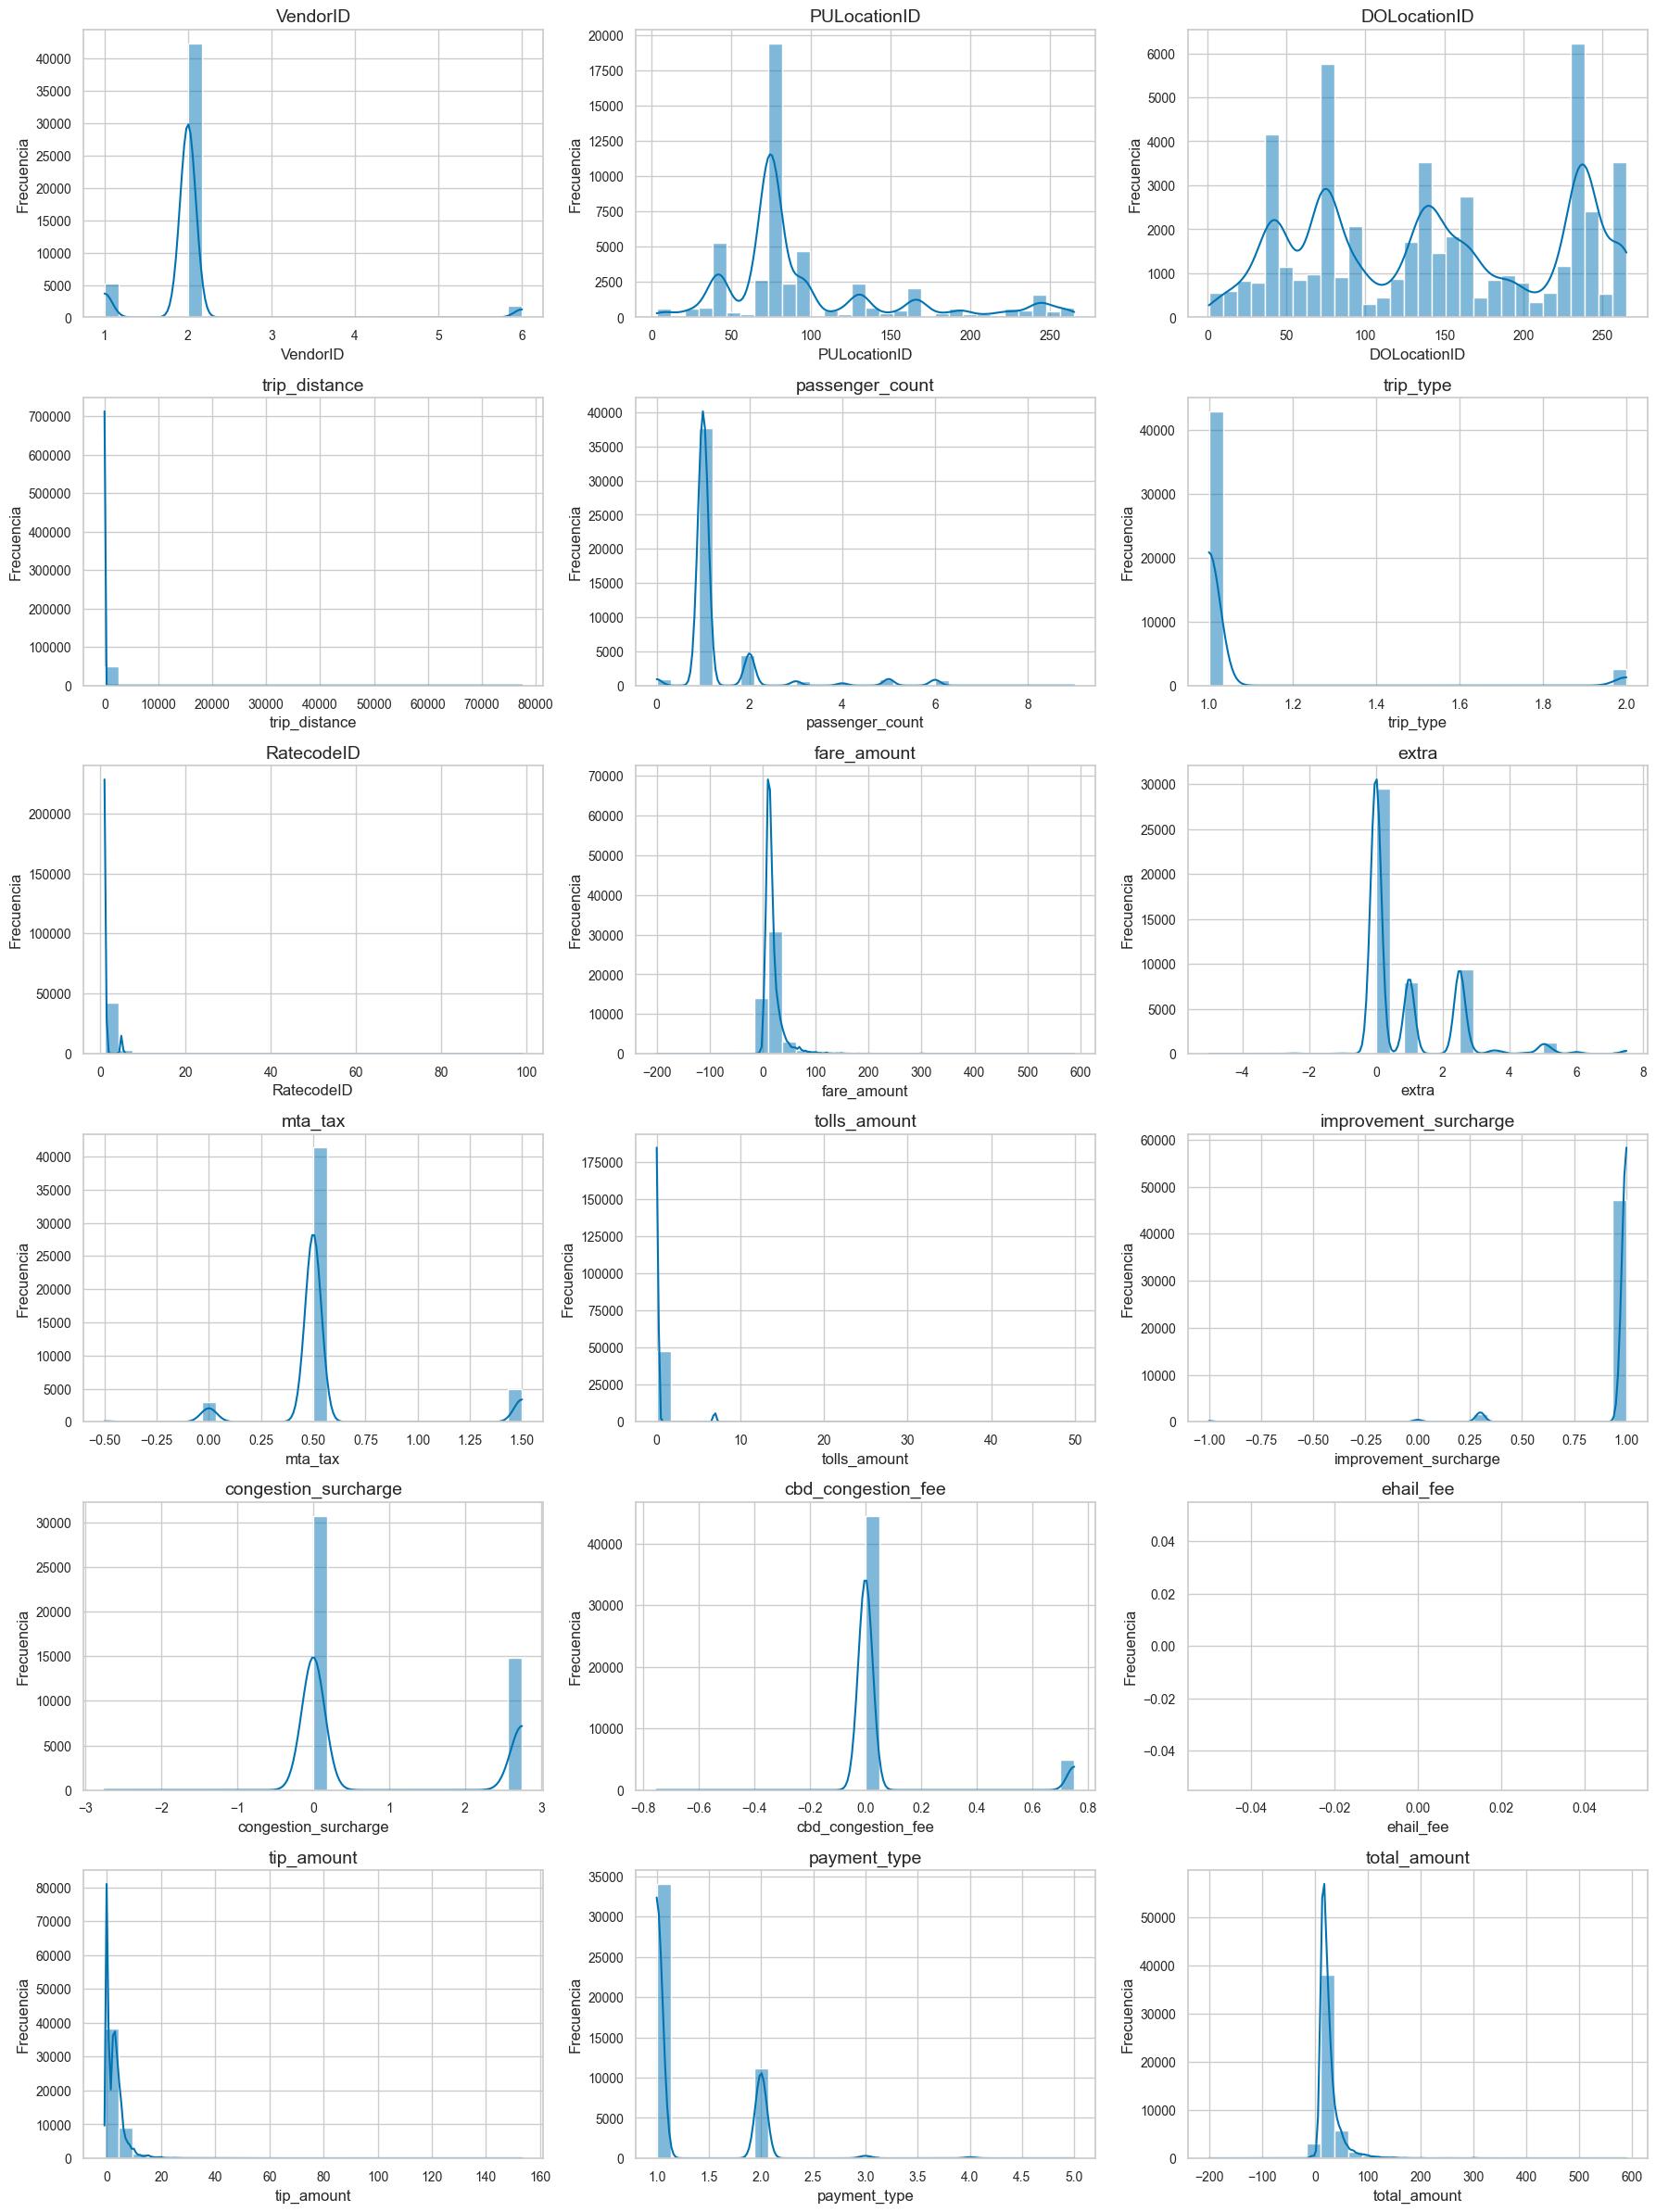

In [27]:
# Histogramas de todas las variables numéricas en un solo gráfico
numeric_cols = df.select_dtypes(include=['float64', 'int32']).columns
num_plots = len(numeric_cols)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols  # Calcular número de filas necesarias
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 4))
for i, col in enumerate(numeric_cols):
    ax = axes[i // num_cols, i % num_cols]
    sns.histplot(df[col].dropna(), bins=30, kde=True, ax=ax)
    ax.set_title(f'{col}')
    plt.tight_layout()
    ax.set_xlabel(col)
    ax.set_ylabel('Frecuencia')


Columnas numéricas originales: 18
Columnas numéricas después de filtrar: 12
Columnas excluidas: {'passenger_count', 'trip_type', 'VendorID', 'RatecodeID', 'payment_type', 'ehail_fee'}


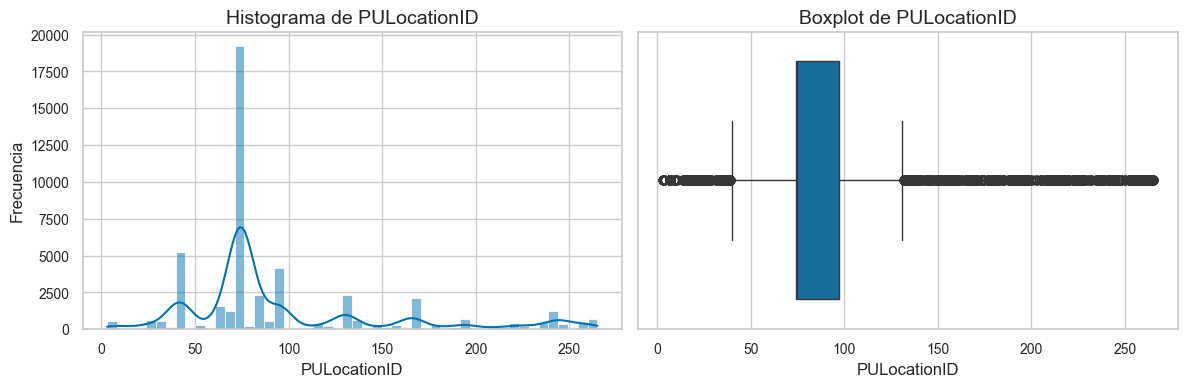

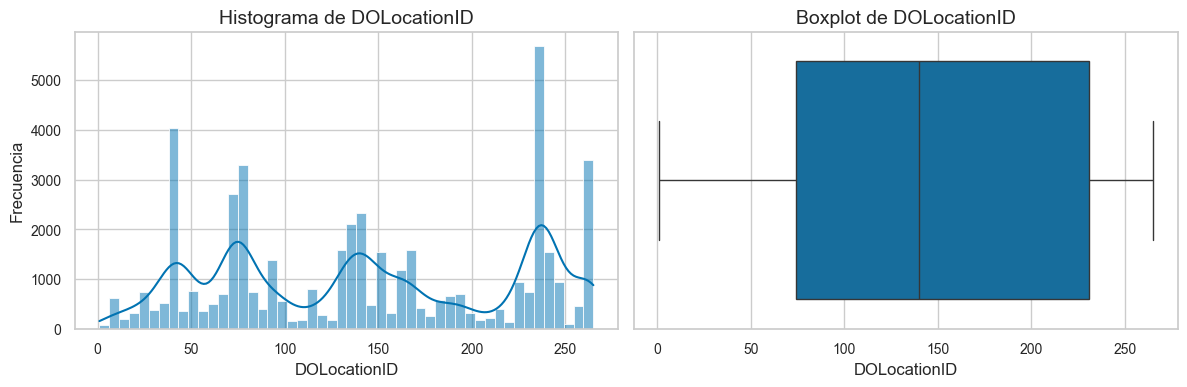

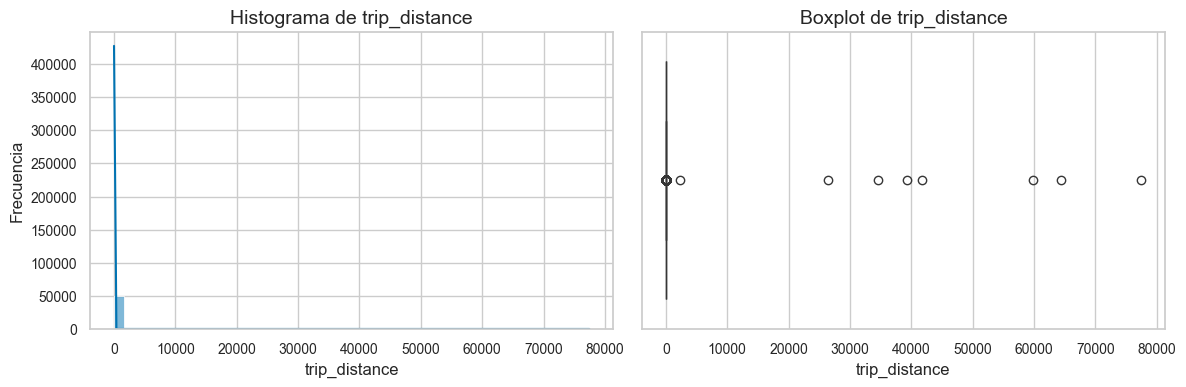

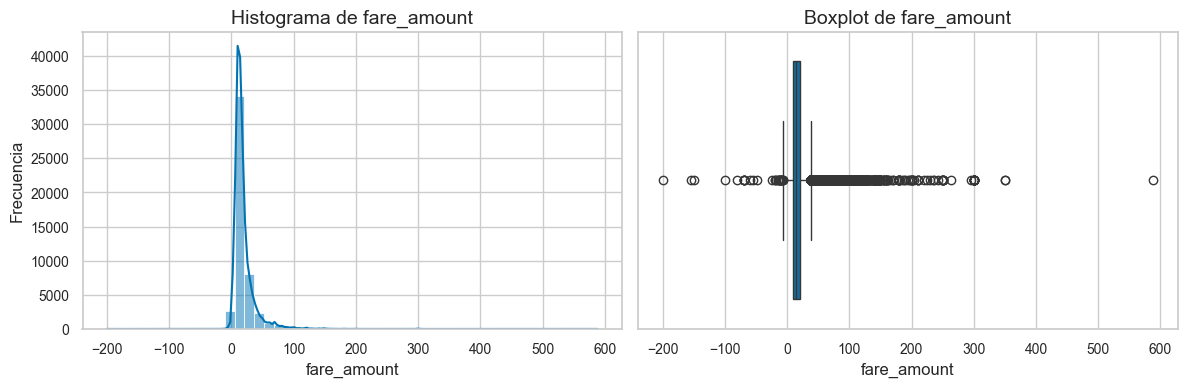

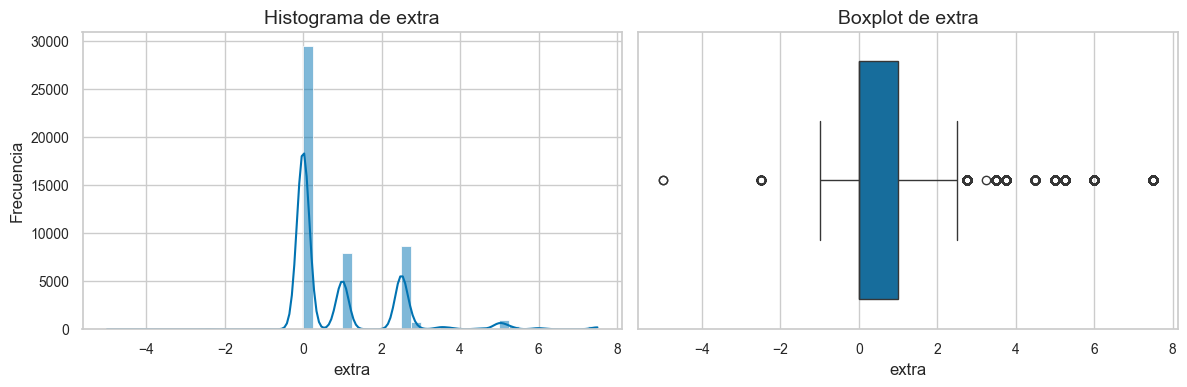

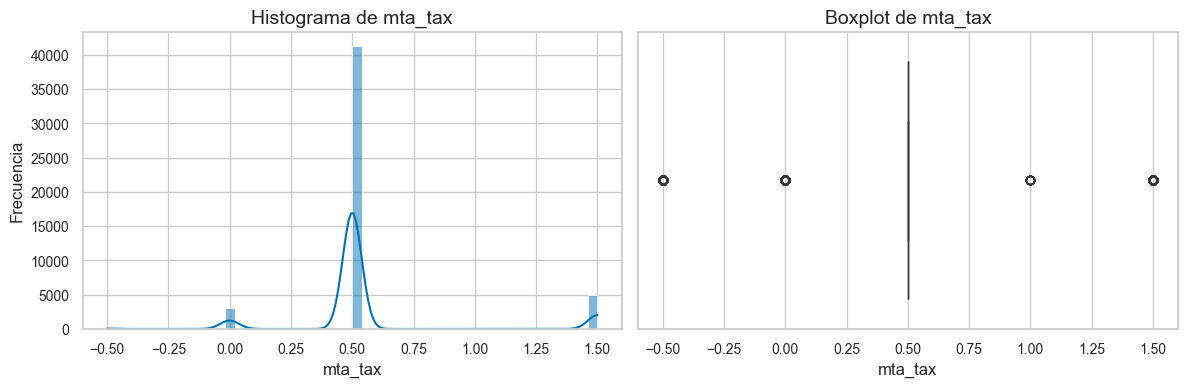

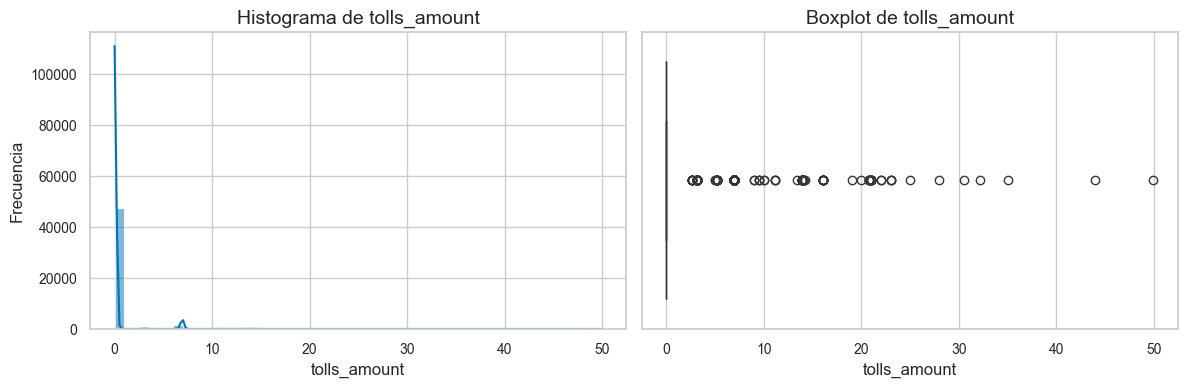

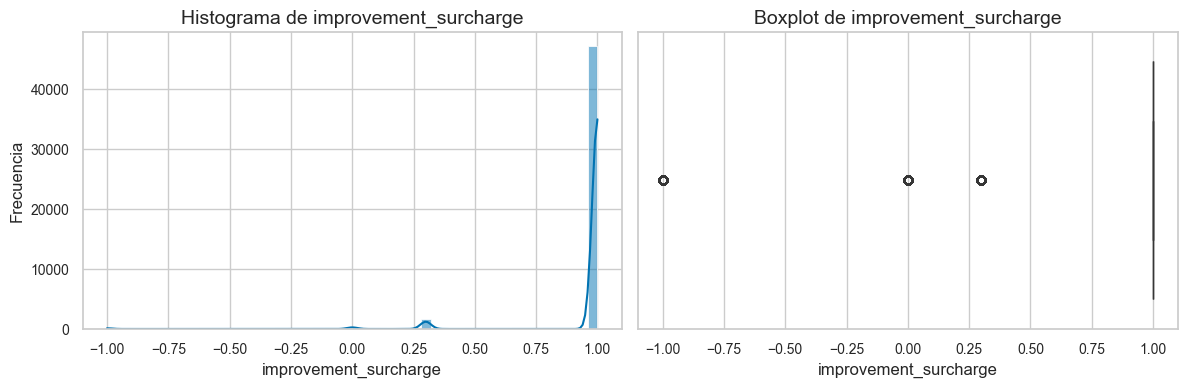

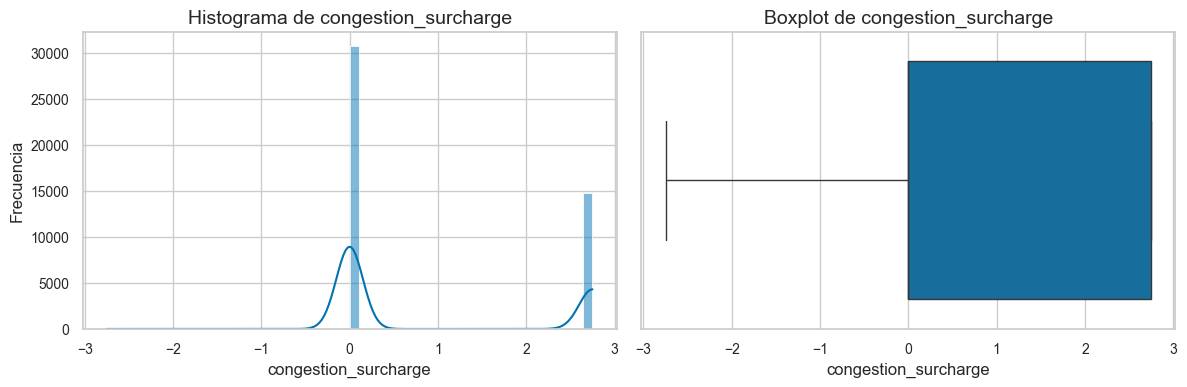

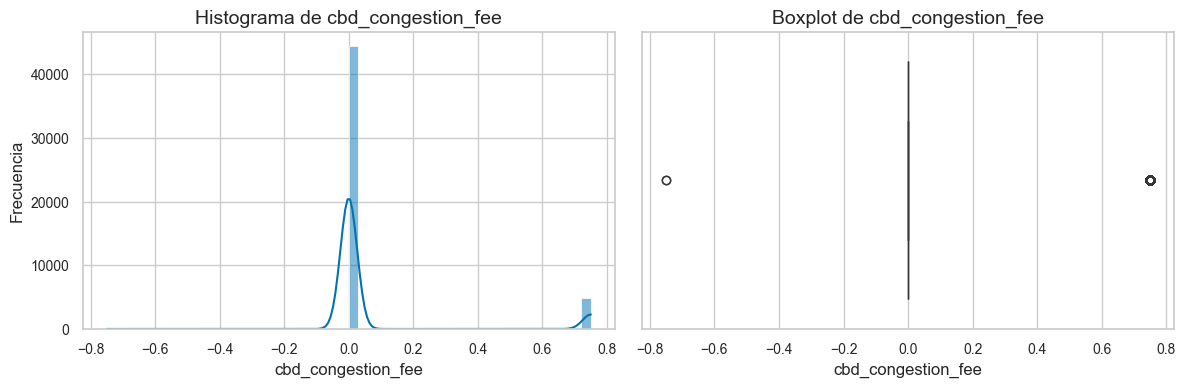

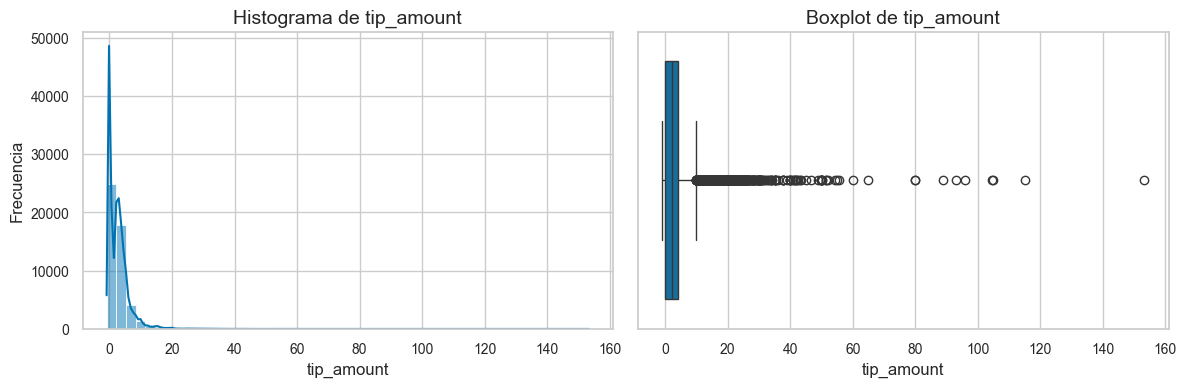

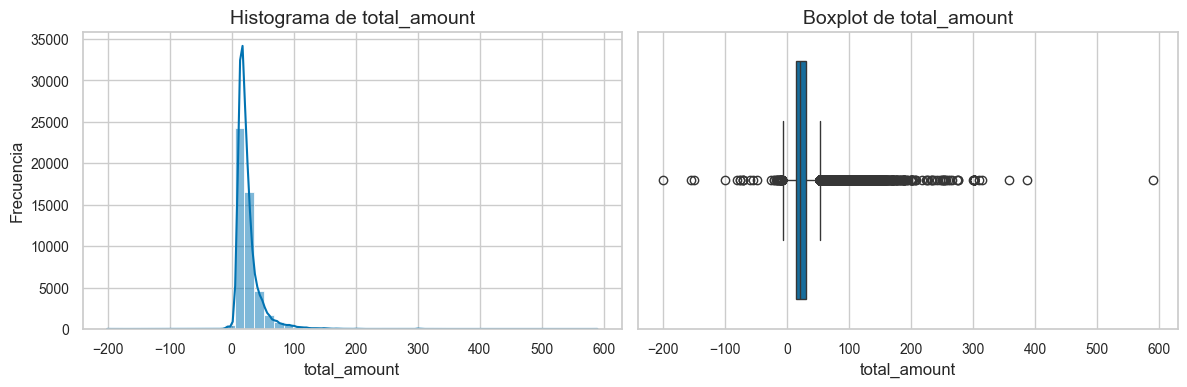

In [28]:
# Lista de columnas a excluir
columns_to_exclude = ['VendorID', 'RatecodeID', 'passenger_count', 'trip_type', 
                     'ehail_fee', 'payment_type', 'trip_type']  # Nota: 'trip_type' está duplicado

# Filtrar columnas numéricas excluyendo las especificadas
filtered_numeric_cols = [col for col in numeric_cols if col not in columns_to_exclude]

print(f"Columnas numéricas originales: {len(numeric_cols)}")
print(f"Columnas numéricas después de filtrar: {len(filtered_numeric_cols)}")
print(f"Columnas excluidas: {set(numeric_cols) - set(filtered_numeric_cols)}")

# Histogramas y Boxplots solo con columnas filtradas
for col in filtered_numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    col_data = df[col].dropna()

    if col_data.empty:
        axes[0].set_title(f"Histograma de {col}")
        axes[0].text(0.5, 0.5, "Sin datos disponibles", ha="center", va="center")
        axes[0].set_axis_off()

        axes[1].set_title(f"Boxplot de {col}")
        axes[1].text(0.5, 0.5, "Sin datos disponibles", ha="center", va="center")
        axes[1].set_axis_off()

        plt.tight_layout()
        plt.show()
        continue

    # Histograma
    sns.histplot(col_data, bins=50, kde=True, ax=axes[0])
    axes[0].set_title(f"Histograma de {col}")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frecuencia')

    # Boxplot
    sns.boxplot(x=col_data, ax=axes[1])
    axes[1].set_title(f"Boxplot de {col}")
    axes[1].set_xlabel(col)

    plt.tight_layout()
    plt.show()

In [29]:
# ANÁLISIS DE OUTLIERS
# Primero, identificar todas las columnas numéricas disponibles
all_numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# 1. ANÁLISIS DE OUTLIERS POR REGLAS DE NEGOCIO
print("\n" + "="*50)
print("OUTLIERS POR REGLAS DE NEGOCIO")
print("="*50)

# Definir reglas de negocio específicas para cada variable
business_rules_outliers = {}

# Reglas basadas en el dominio de taxis NYC
business_rules = {
    'PULocationID': {
        'condition': lambda x: (x < 1) | (x > 150),  # IDs de zona TLC válidos: 1-150
        'description': 'IDs de zona TLC inválidos (fuera de 1-150)'
    },
    'trip_distance': {
    'condition': lambda x: (x < 0) | (x > 2000),  # Distancias negativas o > 2000 metros
    'description': 'Distancias negativas o mayores a 2000 metros'
    }
    ,
    'fare_amount': {
        'condition': lambda x: (x < 0) | (x > 200),  # Tarifas negativas o > $200
        'description': 'Tarifas negativas o mayores a $200'
    },
    'extra': {
        'condition': lambda x: (x < 0) | (x > 3),  # Extras negativos o > $3
        'description': 'Cargos extra negativos o mayores a $3'
    },
    'mta_tax': {
        'condition': lambda x: (x < 0) | (x > 1.25),  # Impuestos MTA negativos o > $1.25
        'description': 'Impuestos MTA negativos o mayores a $1.25'
    },
    """
    'trip_duration': {
        'condition': lambda x: (x < 60) | (x > 3600 * 3),  # < 1 minuto o > 3 horas
        'description': 'Duración menor a 1 minuto o mayor a 3 horas'
    },
    """
    'total_amount': {
        'condition': lambda x: (x < 0) | (x > 200),  # Montos negativos o > $200
        'description': 'Montos totales negativos o mayores a $200'
    },
    'improvement_surcharge': {
        'condition': lambda x: (x < 0) | (x > 10),  # Cargos negativos o > $10
        'description': 'Cargos por mejora negativos o mayores a $10'
    },
    'tip_amount': {
        'condition': lambda x: (x < 0) | (x > 100),  # Propinas negativas o > $100
        'description': 'Propinas negativas o mayores a $100'
    },
    'tolls_amount': {
        'condition': lambda x: (x < 0) | (x > 50),  # Peajes negativos o > $50
        'description': 'Peajes negativos o mayores a $50'
    }
}

# Aplicar reglas de negocio a cada columna disponible
for col, rules in business_rules.items():
    if col in df.columns:
        outliers_mask = rules['condition'](df[col])
        outliers_count = outliers_mask.sum()
        outliers_pct = (outliers_count / len(df)) * 100
        
        business_rules_outliers[col] = {
            'count': outliers_count,
            'percentage': outliers_pct,
            'description': rules['description'],
            'examples': df.loc[outliers_mask, col].head(5).tolist() if outliers_count > 0 else []
        }
        
        print(f"{col}: {outliers_count:,} outliers ({outliers_pct:.2f}%) - {rules['description']}")


OUTLIERS POR REGLAS DE NEGOCIO
PULocationID: 8,112 outliers (16.42%) - IDs de zona TLC inválidos (fuera de 1-150)
trip_distance: 8 outliers (0.02%) - Distancias negativas o mayores a 2000 metros
fare_amount: 193 outliers (0.39%) - Tarifas negativas o mayores a $200
extra: 2,367 outliers (4.79%) - Cargos extra negativos o mayores a $3
mta_tax: 5,056 outliers (10.24%) - Impuestos MTA negativos o mayores a $1.25
improvement_surcharge: 159 outliers (0.32%) - Cargos por mejora negativos o mayores a $10
tip_amount: 6 outliers (0.01%) - Propinas negativas o mayores a $100
tolls_amount: 0 outliers (0.00%) - Peajes negativos o mayores a $50


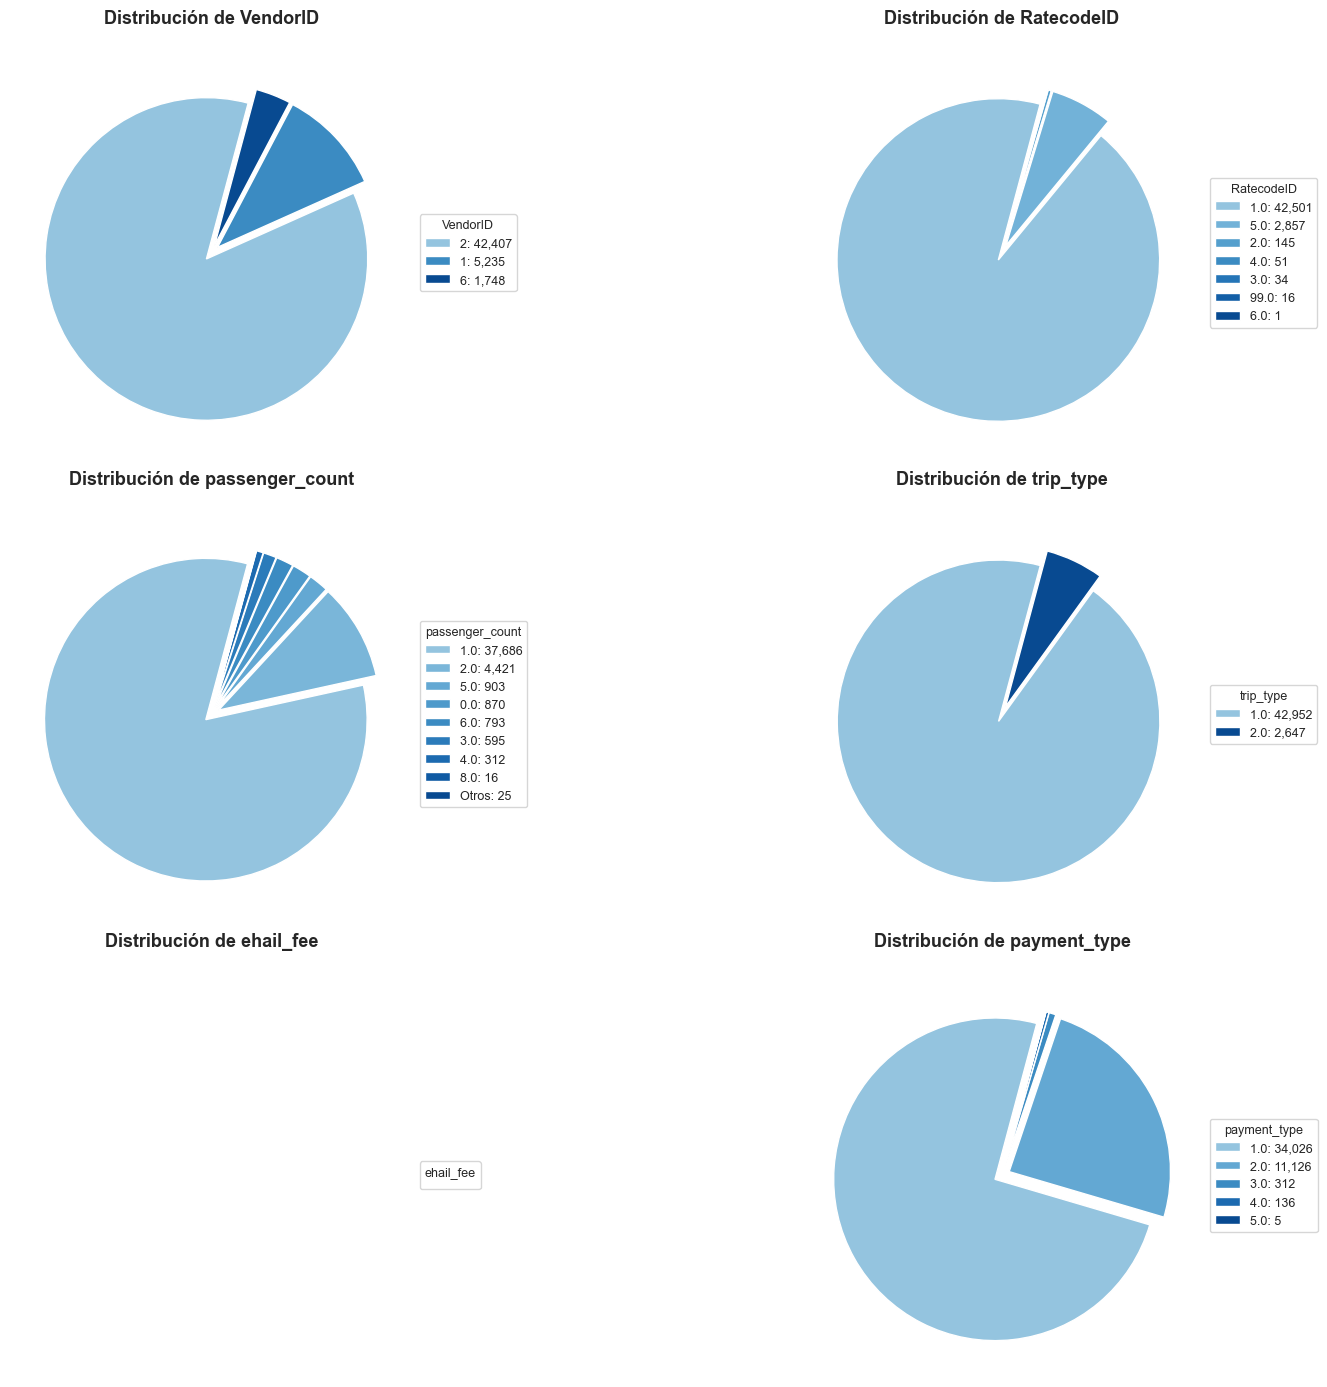

In [30]:
# Gráficos Pie para variables categóricas
categorical_vars = ['VendorID', 'RatecodeID', 'passenger_count', 
                   'trip_type', 'ehail_fee', 'payment_type']

fig, axes = plt.subplots(3, 2, figsize=(18, 14))
axes = axes.flatten()

for i, col in enumerate(categorical_vars):
    if col not in df.columns:
        axes[i].text(0.5, 0.5, f'{col}\nNo disponible', ha='center', va='center', fontsize=12)
        axes[i].set_title(f'{col} - No encontrado')
        continue
    
    # Calcular conteos y agrupar si hay muchos valores
    value_counts = df[col].value_counts()
    if len(value_counts) > 8:
        plot_data = value_counts.head(8)
        plot_data['Otros'] = value_counts[8:].sum()
    else:
        plot_data = value_counts
    
    # Crear pie chart sin porcentajes ni valores
    colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(plot_data)))
    
    wedges, texts = axes[i].pie(
        plot_data.values, 
        labels=None,  # Eliminamos las etiquetas del pie
        autopct=None,  # Eliminamos los porcentajes
        colors=colors,
        startangle=75,
        explode=(0.05,) * len(plot_data)
    )
    axes[i].set_title(f'Distribución de {col}', fontweight='bold', fontsize=13, pad=20)
    
    # Crear leyenda fuera del gráfico con la información
    axes[i].legend(
        wedges, 
        [f'{label}: {val:,}' for label, val in zip(plot_data.index, plot_data.values)],
        title=col,
        loc="center left",
        bbox_to_anchor=(1, 0, 0.75, 1),
        title_fontsize='9',
        fontsize=9
    )
plt.tight_layout()
plt.show()

En este código se generan histogramas y boxplots para las variables numéricas trip_distance y fare_amount. Los histogramas muestran la distribución de los datos, mientras que los boxplots ayudan a identificar posibles outliers.

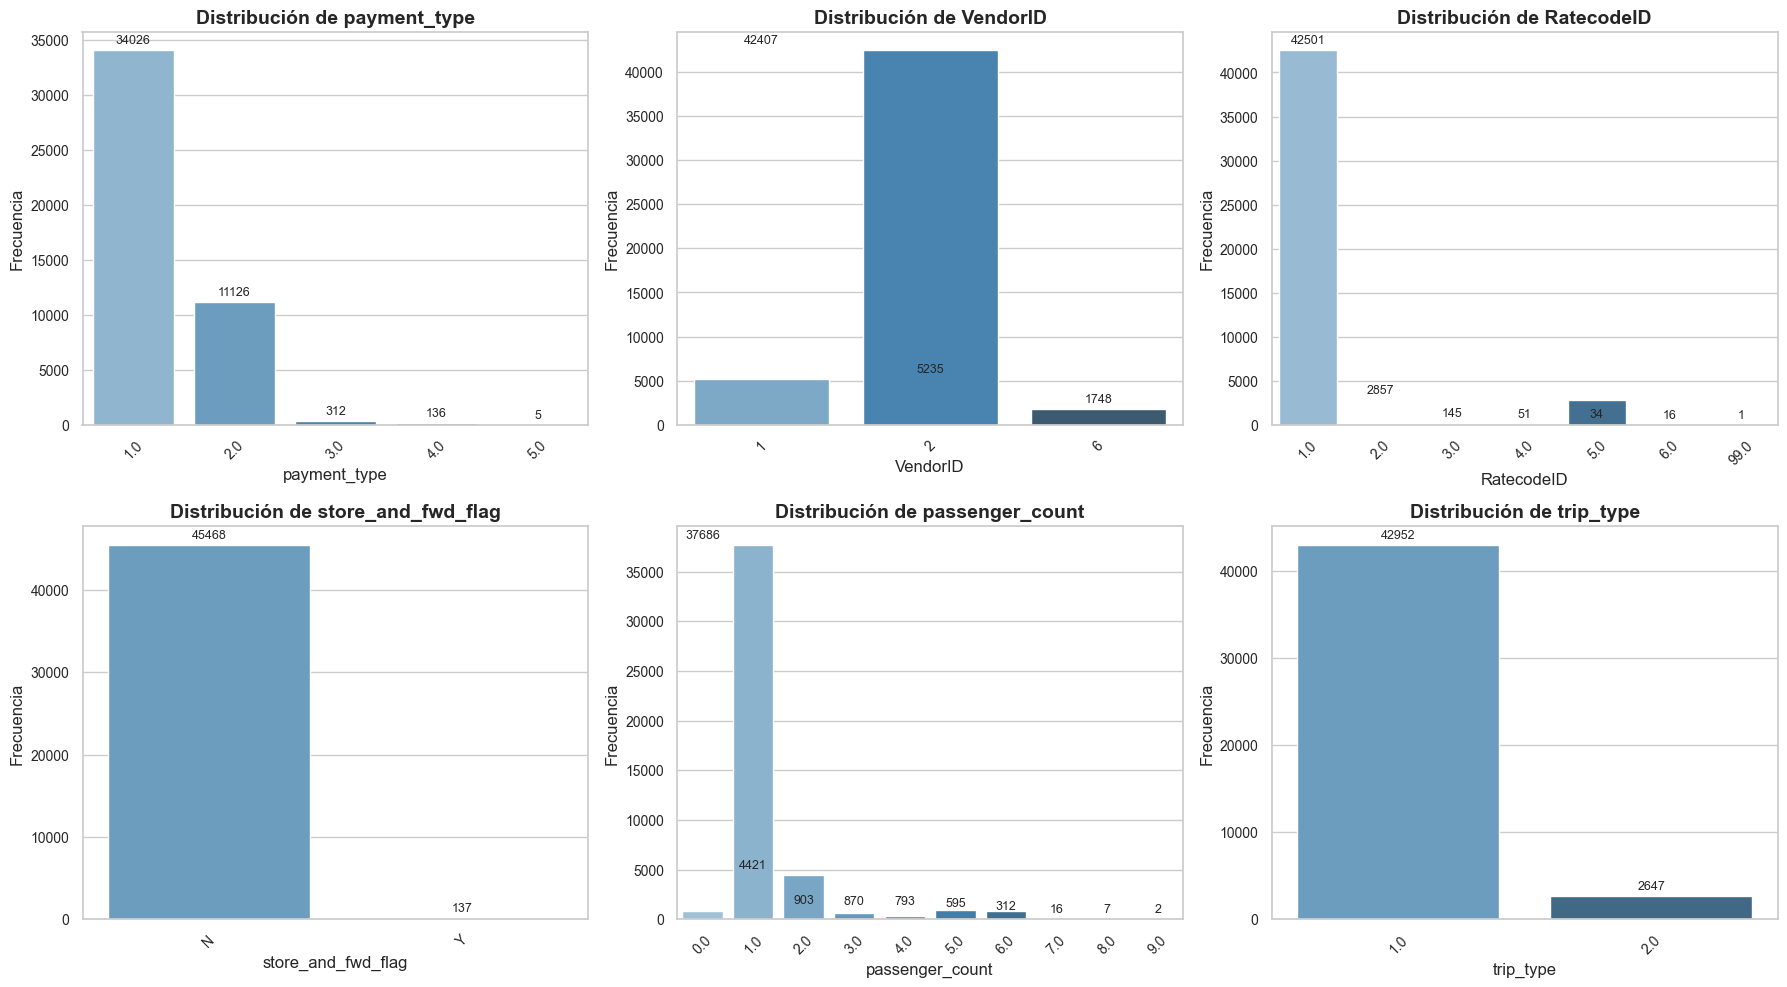

In [31]:
# Frecuencias de variables categóricas
cat_cols = ["payment_type", "VendorID", "RatecodeID", "store_and_fwd_flag", "passenger_count", "trip_type"]

# Grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    # Crear gráfico de barras
    value_counts = df[col].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[i], palette="Blues_d")
    axes[i].set_title(f"Distribución de {col}", fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')
    
    # Rotar etiquetas si es necesario
    axes[i].tick_params(axis='x', rotation=45)
    
    # Añadir valores en las barras
    for j, v in enumerate(value_counts.values):
        axes[i].text(j, v + max(value_counts.values) * 0.01, str(v), 
                    ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

In [32]:
# Spreadsheet para diccionario de datos completo
data_types['Descripción (Español)'] = [
    'Código del proveedor del servicio',                # VendorID
    'Fecha y hora de inicio del viaje',                 # lpep_pickup_datetime
    'Fecha y hora de fin del viaje',                    # lpep_dropoff_datetime
    'Indicador de almacenamiento temporal en vehículo', # store_and_fwd_flag
    'Código de tarifa aplicada al viaje',               # RatecodeID
    'Zona de recogida del pasajero',                    # PULocationID
    'Zona de destino del pasajero',                     # DOLocationID
    'Número de pasajeros en el viaje',                  # passenger_count
    'Distancia recorrida en millas',                    # trip_distance
    'Tarifa base del viaje',                            # fare_amount
    'Cargos adicionales y suplementos',                 # extra
    'Impuesto MTA aplicado',                            # mta_tax
    'Propina pagada (solo tarjeta)',                    # tip_amount
    'Monto total de peajes',                            # tolls_amount
    'Tarifa de servicio e-hail (obsoleta)',            # ehail_fee
    'Recargo por mejora del servicio',                  # improvement_surcharge
    'Monto total cobrado al pasajero',                  # total_amount
    'Método de pago utilizado',                         # payment_type
    'Tipo de servicio (calle/despacho)',               # trip_type
    'Recargo por congestión de NYS',                   # congestion_surcharge
    'Tarifa por congestión Zona CBD MTA'               # cbd_congestion_fee
]
data_types = data_types[['Variable','Descripción (Español)']]
data_types

,Variable,Descripción (Español)
0,VendorID,Código del proveedor del servicio
1,lpep_pickup_datetime,Fecha y hora de inicio del viaje
2,lpep_dropoff_datetime,Fecha y hora de fin del viaje
3,PULocationID,Indicador de almacenamiento temporal en vehículo
4,DOLocationID,Código de tarifa aplicada al viaje
5,trip_distance,Zona de recogida del pasajero
6,passenger_count,Zona de destino del pasajero
7,trip_type,Número de pasajeros en el viaje
8,store_and_fwd_flag,Distancia recorrida en millas
9,RatecodeID,Tarifa base del viaje


Configuración cargada exitosamente con joblib


<Figure size 2000x1600 with 0 Axes>

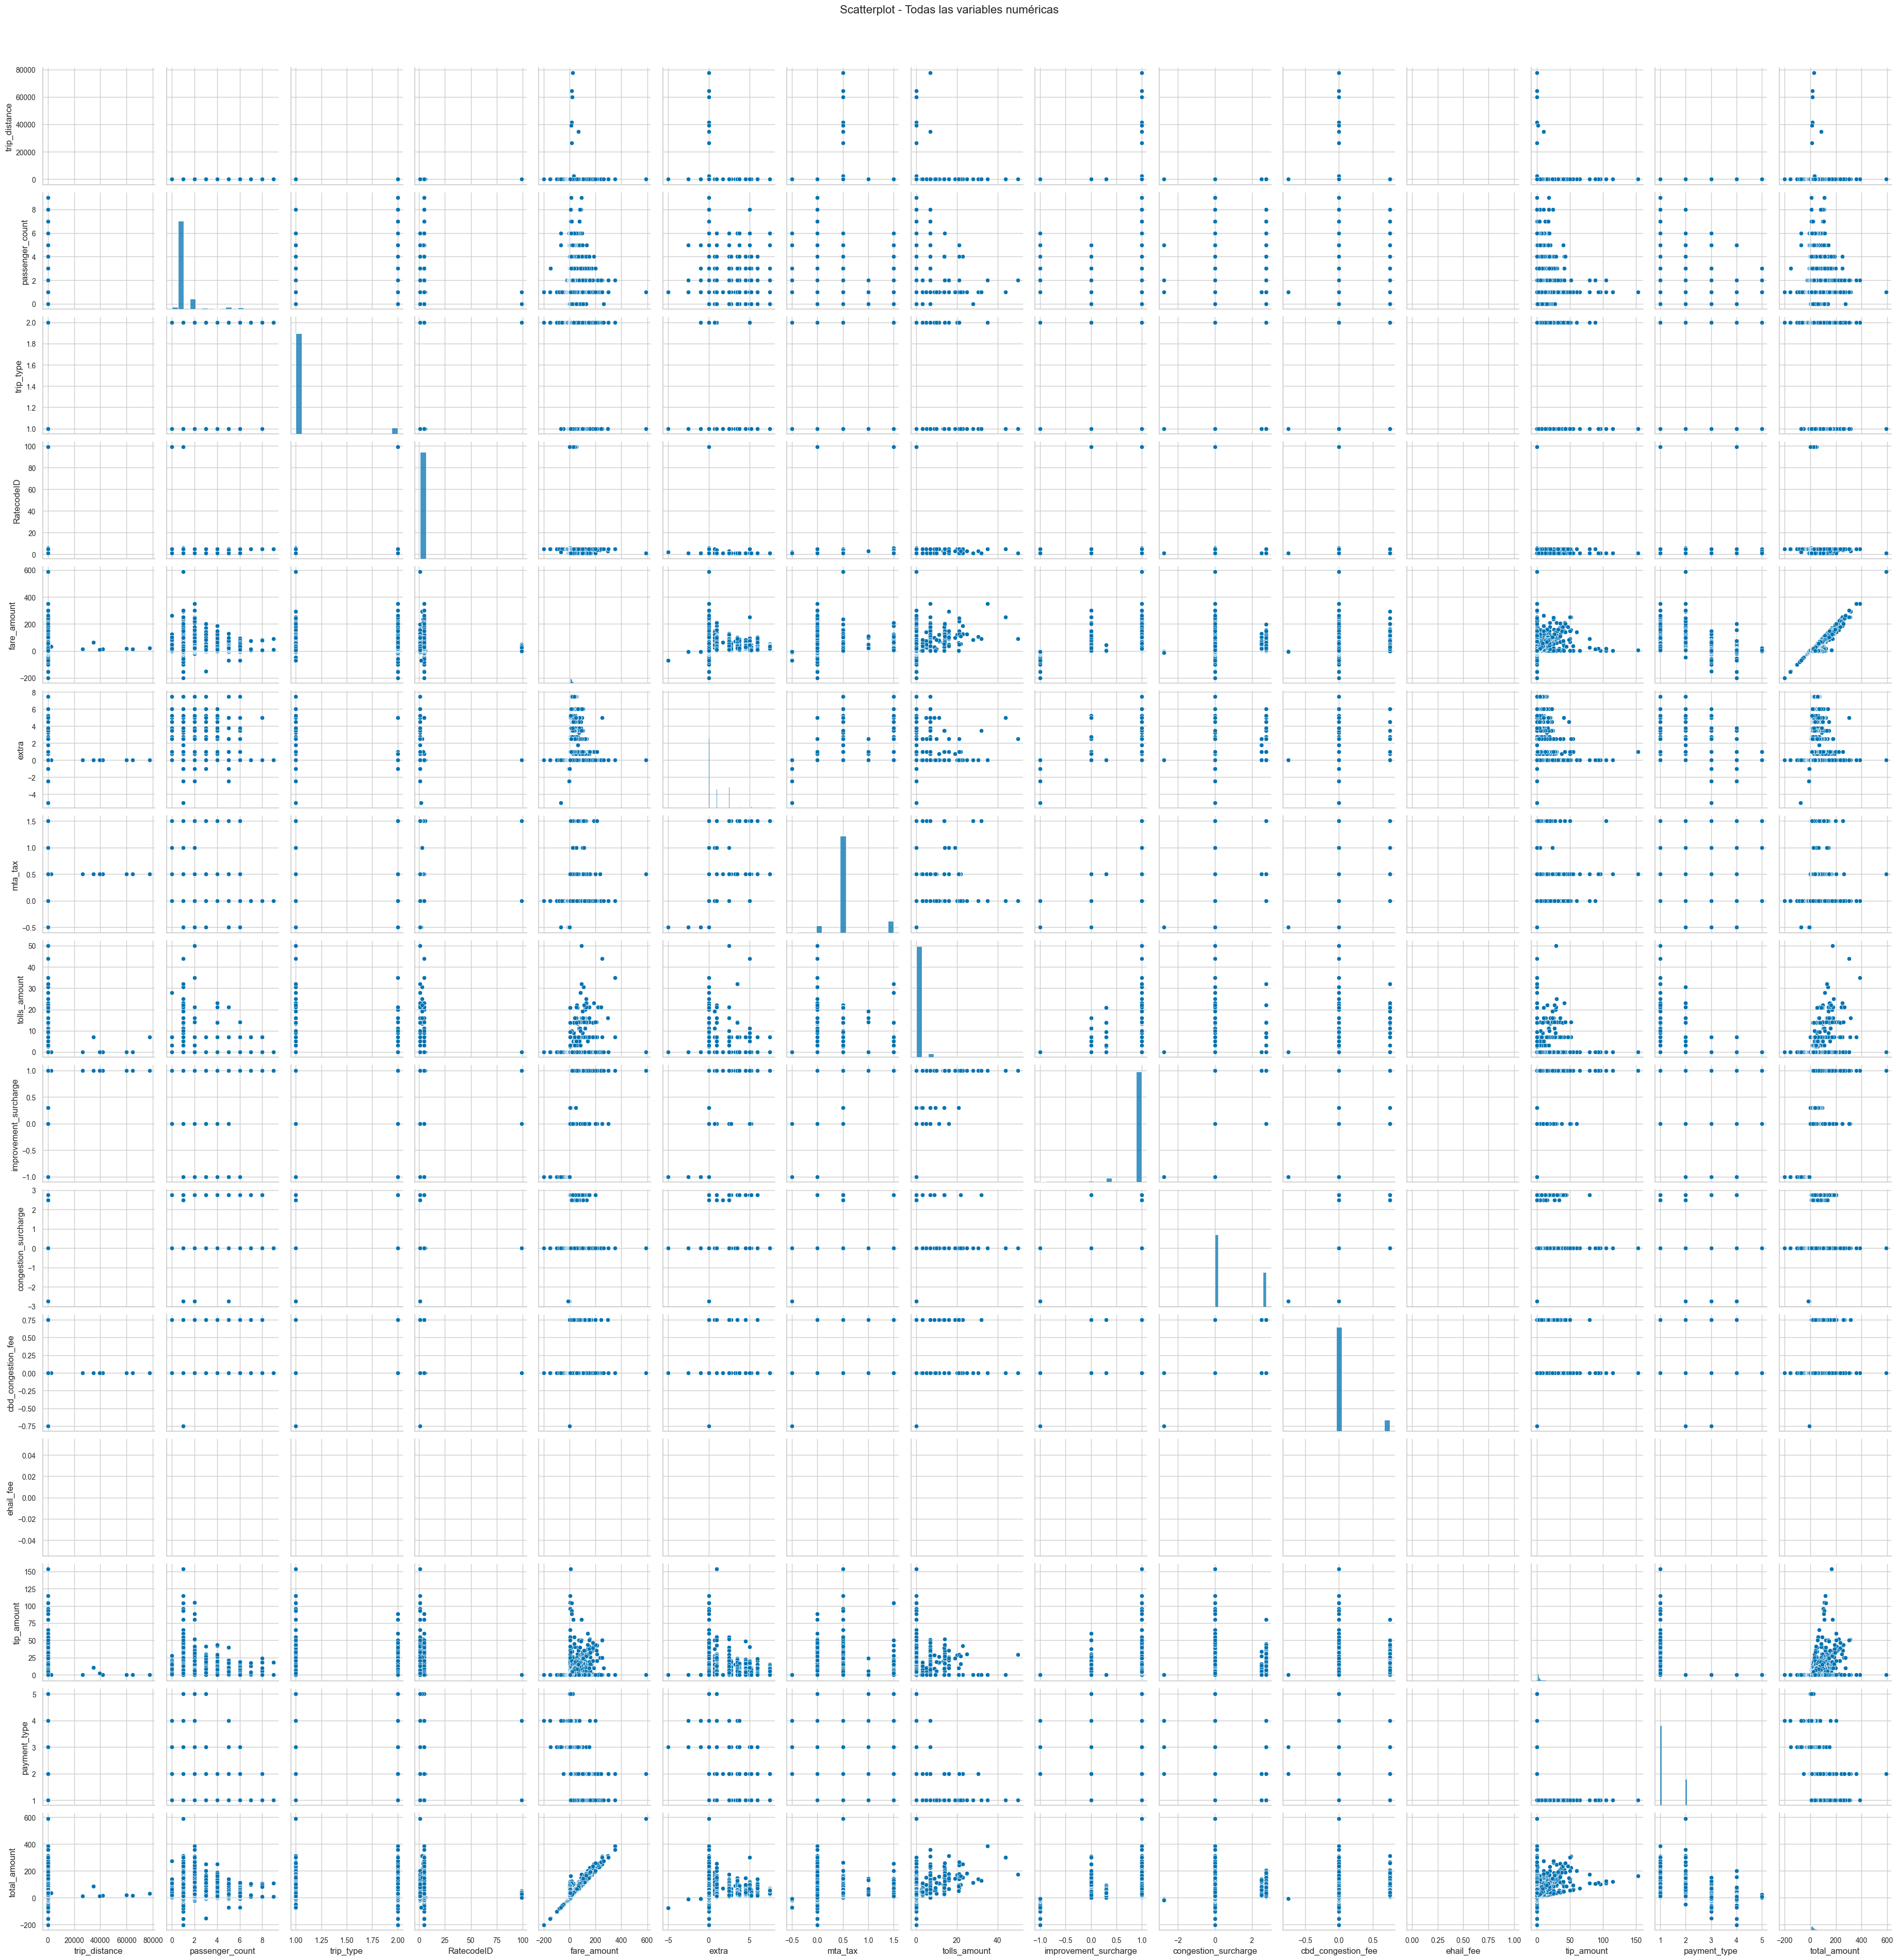

In [33]:
# Pairplot con joblib y verificación de cambios
config_file = 'pairplot_config.joblib'

# Obtener columnas numéricas actuales
current_numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
current_shape = df[current_numeric_cols].shape

# Verificar si existe configuración previa
try:
    config = joblib.load(config_file)
    
    # Verificar si los datos han cambiado
    data_changed = (config.get('data_shape') != current_shape or set(config.get('numeric_cols', [])) != set(current_numeric_cols))
    
    if data_changed:
        print("Datos han cambiado, actualizando configuración...")
        raise FileNotFoundError  # Forzar recreación
    else:
        numeric_cols = config['numeric_cols']
        print("Configuración cargada exitosamente con joblib")
        
except:
    # Crear nueva configuración
    numeric_cols = current_numeric_cols
    if len(numeric_cols) > 21:
        numeric_cols = numeric_cols[:21]

    config = {
        'numeric_cols': list(numeric_cols),
        'timestamp': pd.Timestamp.now(),
        'data_shape': current_shape
    }
    joblib.dump(config, config_file)
    print("Nueva configuración guardada con joblib")

# Crear el pairplot
plt.figure(figsize=(20, 16))
sns.pairplot(df[numeric_cols])
plt.suptitle('Scatterplot - Todas las variables numéricas', y=1.02, fontsize=16)
plt.show()

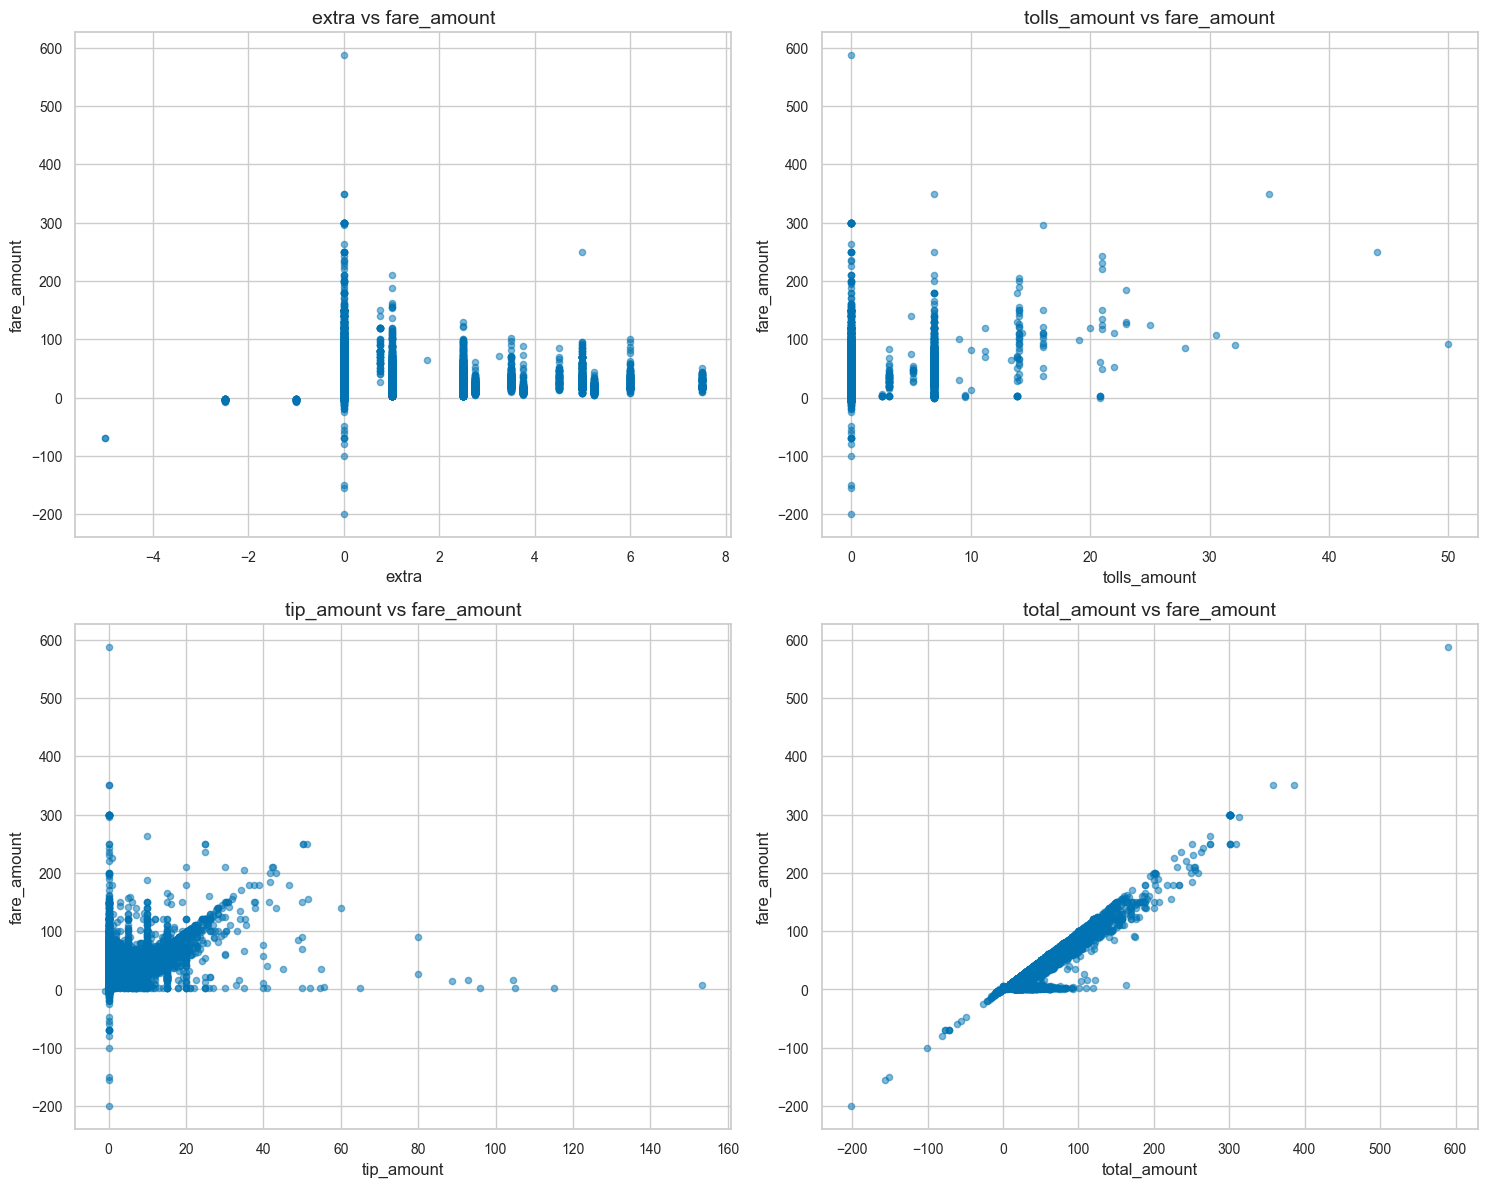

In [34]:
# Scatter plots básicos con joblib
selected_pairs = [
    ('extra', 'fare_amount'),
    ('tolls_amount', 'fare_amount'),
    ('tip_amount', 'fare_amount'),
    ('total_amount', 'fare_amount'),
]
# Guardar con joblib (una línea)
joblib.dump(selected_pairs, 'pares_scatter.joblib')
# Crear plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
for ax, (x, y) in zip(axes.flat, selected_pairs):
    df.plot.scatter(x=x, y=y, alpha=0.5, ax=ax)
    ax.set_title(f'{x} vs {y}')
plt.tight_layout()
plt.show()

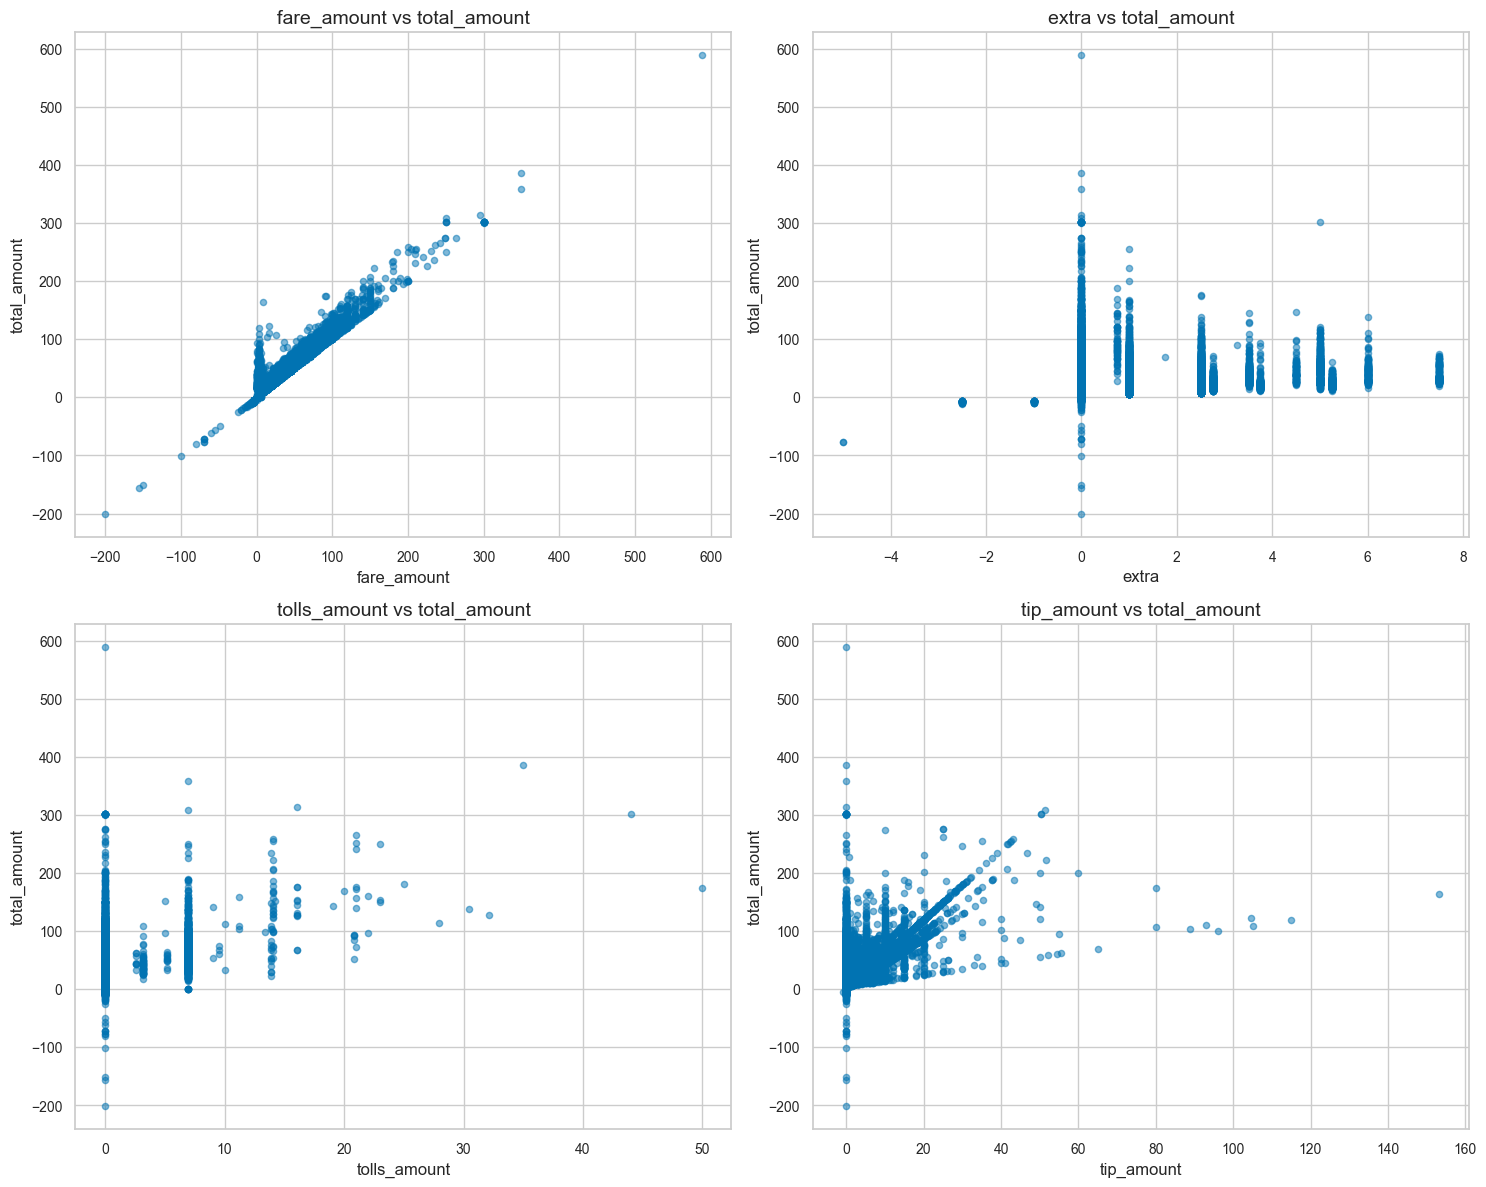

In [35]:
# Scatter plots básicos con joblib
selected_pairs = [
    ('fare_amount', 'total_amount'),
    ('extra', 'total_amount'),
    ('tolls_amount', 'total_amount'),
    ('tip_amount', 'total_amount'),
    ('tip_amount', 'extra'),
]
# Guardar con joblib (una línea)
joblib.dump(selected_pairs, 'pares_scatter.joblib')
# Crear plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
for ax, (x, y) in zip(axes.flat, selected_pairs):
    df.plot.scatter(x=x, y=y, alpha=0.5, ax=ax)
    ax.set_title(f'{x} vs {y}')
plt.tight_layout()
plt.show()

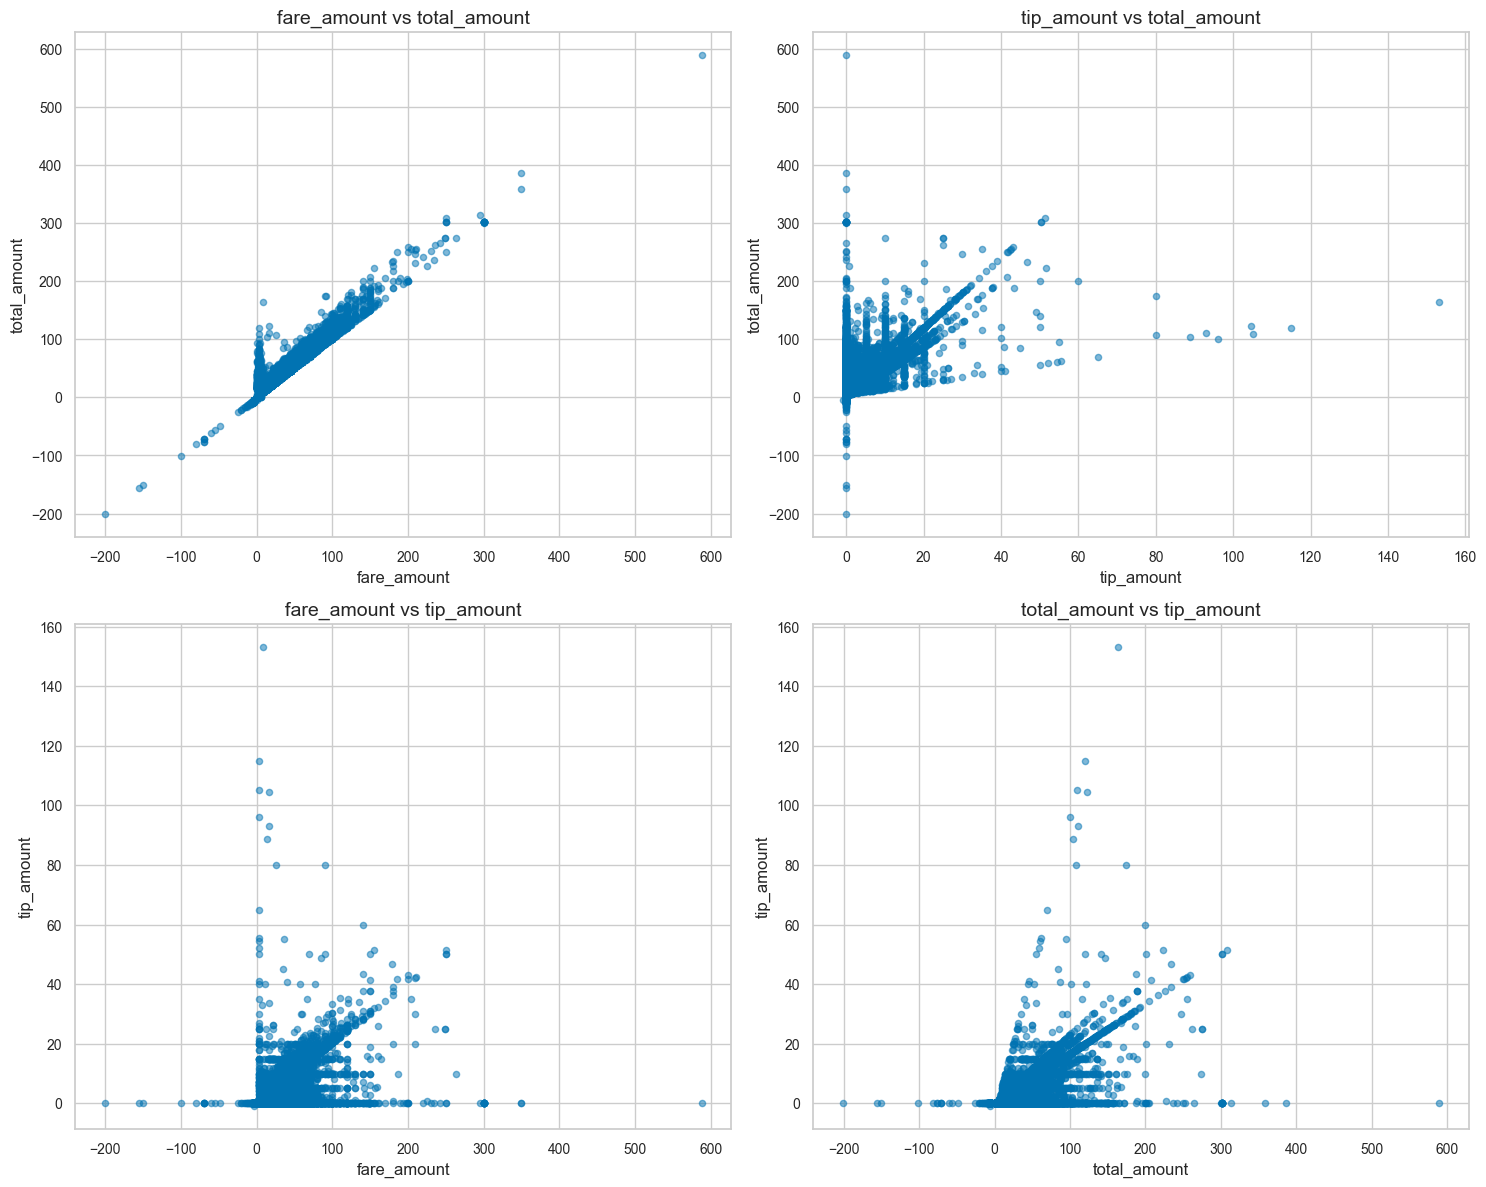

In [36]:
# Scatter plots básicos con joblib
selected_pairs = [
    ('fare_amount', 'total_amount'),
    ('tip_amount', 'total_amount'),
    ('fare_amount', 'tip_amount'),
    ('total_amount', 'tip_amount'),
]
# Guardar con joblib (una línea)
joblib.dump(selected_pairs, 'pares_scatter.joblib')
# Crear plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
for ax, (x, y) in zip(axes.flat, selected_pairs):
    df.plot.scatter(x=x, y=y, alpha=0.5, ax=ax)
    ax.set_title(f'{x} vs {y}')
plt.tight_layout()
plt.show()


## EDA 2 - Análisis Bivariado


## Valores Nulos

# Preprocesamiento básico
En esta sección se realiza el preprocesamiento de los datos:
1. Se convierten las columnas de tiempo al formato `datetime` si es necesario.
2. Se calcula la duración del viaje en minutos.
3. Se eliminan registros con valores nulos o negativos en las columnas clave (`trip_distance`, `fare_amount`, `trip_duration`).
4. Se verifica el tamaño del dataset después del filtrado.

In [37]:

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=registros_viajes_eco.sample(5000, random_state=42),  
    x="trip_distance", 
    y="fare_amount", 
    alpha=0.3
)
plt.xlim(0, 50)   # limitar valores extremos
plt.ylim(0, 200)
plt.title("Relación entre distancia del viaje y tarifa")
plt.xlabel("Distancia del viaje (millas)")
plt.ylabel("Tarifa ($)")
plt.show()

NameError: name 'registros_viajes_eco' is not defined

<Figure size 800x600 with 0 Axes>

# Relación entre distancia y tarifa
Se genera un scatterplot para analizar la relación entre la distancia del viaje y la tarifa. Se utiliza una muestra de 5000 registros para mejorar la visualización y se limitan los valores extremos en los ejes para una mejor interpretación.

In [ ]:

plt.figure(figsize=(8,6))
sns.boxplot(
    data=registros_viajes_eco, 
    x="payment_type", 
    y="fare_amount"
)
plt.ylim(0, 100)  # limitar valores extremos
plt.title("Distribución de tarifas según tipo de pago")
plt.xlabel("Tipo de Pago")
plt.ylabel("Tarifa ($)")
plt.show()

# Distribución de tarifas según tipo de pago
Se utiliza un boxplot para visualizar la distribución de tarifas según el tipo de pago. Este gráfico permite identificar la mediana, los cuartiles y los valores atípicos, limitando las tarifas a un máximo de $100 para evitar valores extremos.

In [ ]:
# 7. Análisis temporal: conteo de viajes por hora
registros_viajes_eco["pickup_hour"] = registros_viajes_eco["lpep_pickup_datetime"].dt.hour

plt.figure(figsize=(10,6))
sns.countplot(
    data=registros_viajes_eco, 
    x="pickup_hour"
)
plt.title("Demanda de viajes según la hora del día")
plt.xlabel("Hora del día")
plt.ylabel("Número de viajes")
plt.show()

# Análisis temporal: Demanda por hora
Se analiza la distribución de la demanda de viajes según la hora del día. Se crea una nueva columna `pickup_hour` y se genera un gráfico de barras para visualizar el número de viajes por hora, utilizando la paleta de colores `viridis` para una mejor presentación.

In [ ]:
# Convertir columnas de fecha y hora a formato datetime
data['lpep_pickup_datetime'] = pd.to_datetime(data['lpep_pickup_datetime'])
data['lpep_dropoff_datetime'] = pd.to_datetime(data['lpep_dropoff_datetime'])

## Justificación:

-Convertir las columnas de fecha y hora al formato datetime permite realizar operaciones temporales como calcular la duración del viaje, extraer características como la hora o el día, y analizar patrones temporales.

-Esto es esencial para tareas como la identificación de horas pico, estacionalidad, y análisis de demanda.

In [ ]:
# Crear nuevas características temporales
data['pickup_hour'] = data['lpep_pickup_datetime'].dt.hour
data['pickup_day'] = data['lpep_pickup_datetime'].dt.day_name()
data['pickup_month'] = data['lpep_pickup_datetime'].dt.month

## Justificación:

-pickup_hour: Permite analizar cómo varían las tarifas y la demanda a lo largo del día. Esto es útil para identificar horas pico y optimizar la asignación de vehículos.

-pickup_day: Ayuda a distinguir patrones entre días de la semana, como diferencias entre días laborales y fines de semana.

-pickup_month: Aunque en este caso el dataset es de un solo mes, esta característica sería útil para analizar tendencias a largo plazo si se tienen datos de varios meses.

In [ ]:
# Seleccionar solo columnas numéricas para la matriz de correlación
numeric_data = registros_viajes_eco.select_dtypes(include=['float64', 'int32'])
# Calcular la matriz de correlación
corr = numeric_data.corr()
# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 8))
# Crear el mapa de calor
sns.heatmap(corr, annot=True, fmt=".2f", cmap='Blues', square=True, cbar_kws={"shrink": .8})
plt.title("Matriz de Correlación entre Variables Numéricas")
plt.show()


In [ ]:
# 2. Comparar tarifas y duraciones por zonas geográficas (si están disponibles)
if 'PULocationID' in data.columns and 'DOLocationID' in data.columns:
    top_pickup_zones = data['PULocationID'].value_counts().head(10).index
    filtered_data = data[data['PULocationID'].isin(top_pickup_zones)]
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='PULocationID', y='fare_amount', data=filtered_data)
    plt.title("Distribución de tarifas por zonas de recogida (Top 10)")
    plt.xlabel("Zona de recogida (PULocationID)")
    plt.ylabel("Tarifa ($)")
    plt.show()

## Justificación:
Analisamos y comparamos las tarifas en las 10 zonas de recogida más frecuentes (PULocationID).
Ayuda a identificar zonas con tarifas más altas o más bajas, lo que puede ser útil para la planificación de precios y la asignación de vehículos.
Los boxplots muestran la variabilidad de las tarifas dentro de cada zona, lo que puede revelar patrones o anomalías.

In [ ]:
# 3. Series temporales: evolución de tarifas y demanda por horas del día
plt.figure(figsize=(12, 6))
sns.lineplot(x='pickup_hour', y='fare_amount', data=data, errorbar=None)
plt.title("Evolución de la tarifa promedio por hora del día")
plt.xlabel("Hora del día")
plt.ylabel("Tarifa promedio ($)")
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data['pickup_hour'], bins=24, kde=False)
plt.title("Demanda de viajes por hora del día")
plt.xlabel("Hora del día")
plt.ylabel("Número de viajes")
plt.show()

## Justificación:
-Evolución de tarifas promedio por hora del día:
Este análisis utiliza un gráfico de líneas para mostrar cómo varía la tarifa promedio a lo largo del día.
Permite identificar patrones horarios, como tarifas más altas durante las horas pico (por ejemplo, temprano en la mañana o al final de la tarde).
Es útil para entender cómo los factores temporales (como la congestión o la demanda) afectan las tarifas.

-Demanda de viajes por hora del día:
El histograma muestra la cantidad de viajes realizados en cada hora del día.
Ayuda a identificar las horas de mayor actividad (horas pico) y las horas de menor demanda.
Este análisis es clave para la planificación operativa, como la asignación de vehículos y conductores.

In [ ]:
# 4. Cruces de múltiples variables: tarifa según distancia y hora del día
plt.figure(figsize=(12, 6))
sns.scatterplot(x='trip_distance', y='fare_amount', hue='pickup_hour', palette='viridis', data=data)
plt.title("Tarifa según distancia y hora del día")
plt.xlabel("Distancia del viaje (millas)")
plt.ylabel("Tarifa ($)")
plt.show()

## Justificación:
-Este análisis utiliza un gráfico de dispersión para explorar la relación entre la distancia del viaje y la tarifa, con la hora del día como una tercera dimensión (hue).

-Permite identificar:
    -Si las tarifas son proporcionales a la distancia.
    -Si hay variaciones significativas en las tarifas según la hora del día.
    -Anomalías, como tarifas inusualmente altas para distancias cortas o tarifas bajas para distancias largas.

In [ ]:
# Crear la columna 'is_weekend' para identificar fines de semana
data['is_weekend'] = data['pickup_day'].isin(['Saturday', 'Sunday'])

# Calcular la mediana recortada
from scipy.stats import trim_mean
trimmed_medians = data.groupby('is_weekend')['fare_amount'].apply(lambda x: trim_mean(x, proportiontocut=0.1))

# Crear el boxplot con la mediana recortada
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_weekend', y='fare_amount', data=data, hue='is_weekend', palette="pastel", legend=False)

# Añadir las medianas recortadas al gráfico con mejor formato
for i, median in enumerate(trimmed_medians):
    plt.text(i, median + 2, f'{median:.2f}', color='blue', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title("Comparación de tarifas: Fines de semana vs Días laborales", fontsize=14, fontweight='bold')
plt.xlabel("¿Es fin de semana?", fontsize=12)
plt.ylabel("Tarifa ($)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Resumen:
EN Este análisis lo que hace es comparar las tarifas entre fines de semana y días laborales utilizando un boxplot. Se incluyen medianas recortadas para una mejor representación de los datos, ayudando a identificar diferencias clave en los patrones de tarifas.

# Conclusión General

En este análisis exploratorio de datos (EDA) se trabajó con el conjunto de datos "Green Taxi Trip Records" de la ciudad de Nueva York. A lo largo del informe, se realizaron diversas etapas de análisis y visualización para comprender mejor las características y patrones presentes en los datos. A continuación, se resumen los hallazgos más relevantes:

**Preprocesamiento de Datos**:
   - Se limpiaron los datos eliminando valores nulos y registros con valores negativos o extremos en variables clave como `trip_distance`, `fare_amount` y `trip_duration`.
   - Se convirtieron las columnas de fecha y hora al formato `datetime`, lo que permitió calcular la duración de los viajes y extraer características temporales como la hora, el día y el mes.

**Análisis Univariado**:
   - Se generaron histogramas y boxplots para analizar la distribución de variables numéricas como `trip_distance` y `fare_amount`. Esto permitió identificar outliers y comprender la variabilidad de los datos.
   - Se calcularon estadísticas descriptivas como la media, mediana y percentiles para obtener una visión general de las variables.

**Análisis Bivariado**:
   - Se exploró la relación entre la distancia del viaje y la tarifa mediante gráficos de dispersión, observando una correlación positiva entre ambas variables.
   - Se analizaron las tarifas según el tipo de pago y se identificaron diferencias significativas en la distribución de tarifas entre métodos de pago.

**Análisis Temporal**:
   - Se estudió la demanda de viajes según la hora del día, identificando horas pico con mayor actividad.
   - Se compararon las tarifas entre fines de semana y días laborales utilizando boxplots, y se incluyó la mediana recortada con márgenes para un análisis más robusto.

**Análisis Geográfico**:
   - Se analizaron las tarifas en las 10 zonas de recogida más frecuentes, observando variaciones significativas en las tarifas según la ubicación.

### Conclusión Final:
Este análisis proporciona una base sólida para comprender los patrones y tendencias en los datos de viajes en taxi. Los hallazgos clave incluyen:
- La relación positiva entre la distancia del viaje y la tarifa.
- Diferencias en las tarifas según el tipo de pago y el día de la semana.
- Horas pico de alta demanda que podrían ser útiles para la planificación operativa.
- Variaciones geográficas en las tarifas que podrían informar estrategias de precios.

Estos resultados pueden ser utilizados para optimizar la operación de taxis, mejorar la experiencia del cliente y desarrollar estrategias de precios más efectivas. Además, el análisis temporal y geográfico puede ser valioso para la planificación de recursos y la toma de decisiones estratégicas.